# GTEx Tissue-Specific RNA-seq Analysis
## *Pancreas*

### Data Overview

[The Genotype-Tissue Expression Project](https://gtexportal.org/home/) collects tissue samples from well-genotyped human donors with the aim of better understanding how gene expression and regulation correspond to genetic variation. By analyzing tissue-specific RNA-seq data, it is possible to identify new expression quantitative trait loci (eQTLs) which can provide further insight into the mechanisms through which genetic changes occur in disease states. 

The general notebook template provides a pipeline for the visualization and analysis of gene read counts from the [GTEx v8 Data Release](https://gtexportal.org/home/datasets). Please refer to the [GTEx Documentation](https://gtexportal.org/home/documentationPage) for specifics on how expression and genotype data were obtained. For the purposes of this analysis, the data was further processed as follows:
- non-coding genes were removed by cross-checking with a list of known human genes obtained from the [NCBI Gene Database](https://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Mammalia/)
- for genes with multiple associated Ensembl IDs, only the entry with the highest variance across samples was retained
- the data was divided into tissue-specific sub-datasets of counts from the relevant samples
- metadata for the relevant samples of each tissue-specific dataset has been formatted for readability

The final data used for this analysis consists of two datasets: 
- *RNA-seq Data*: provides the read counts of each gene (rows) in each sample (columns). 
- *Sample Metadata*: provides metadata for each sample (rows) such as sex, age range, batch IDs, and more (columns). 
The sample_ids found in the metadata table correspond to the column names of the RNA-seq data.

**Note:** This notebook looks specifically at the data from one tissue sample, as listed in the title. 
*For other tissues, please refer to [this repository](https://github.com/MaayanLab/GTExTissueNotebooks).* 

### Analysis Overview 

The RNA-seq data first undergoes normalization and dimensionality reduction via Principle Component Analysis (PCA) and Uniform Manifold Approximation and Projection (UMAP). Samples are then clustered based on their most-associated highly-variable genes and metadata features. The number of clusters is determined based on a modified silhouette score which prioritizes having more clusters over having larger clusters. 

The most up-regulated and down-regulated genes are also identified for each cluster. These genes are used to perform enrichment analysis via the [Enrichr](https://maayanlab.cloud/Enrichr/) API, as well as to search drug signatures that both mimic and reverse each cluster-specific signature via the [L1000FWD](https://maayanlab.cloud/L1000FWD/) API. 

## 0. Notebook Setup
Set appropriate file names and parameters.

In [1]:
import os
import numpy as np
import pandas as pd
import requests
import time
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from umap import UMAP
from scipy.stats import zscore
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from maayanlab_bioinformatics.dge import characteristic_direction
from maayanlab_bioinformatics.normalization import log2_normalize, filter_by_var, zscore_normalize
from maayanlab_bioinformatics.utils import merge
import plotly.express as px
import plotly
import math
from collections import OrderedDict
import json
from react_scatter_board.jupyter_compat import ScatterBoard
from IPython.display import display, IFrame, Markdown, HTML
from textwrap import wrap
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, pairwise_logrank_test
import plotly.graph_objects as go
from react_gsea import ReactGSEA, dataFromResult
from react_gsea.jupyter_compat import ReactGSEA

In [2]:
# dataset selection
data_filename = 'https://appyters.maayanlab.cloud/storage/GTEx_Tissue_RNAseq_Analysis/Pancreas_counts_deduped.tsv'
metadata_filename = 'https://appyters.maayanlab.cloud/storage/GTEx_Tissue_RNAseq_Analysis/metadata/metadata_Pancreas_counts_deduped.tsv'

In [3]:
# analysis parameters
# defaults are based on defaults used by the Seurat R Package for single cell genomics analysis.

n_pca_components = 10
n_neighbors = 40
min_cluster_dist = 0.3
top_n_genes = 2500
max_clusters_calculation = 'root/2'
use_weighted_silhouette_score = True
use_second_deriv_method = True
top_n_genes_enrichment = 250
heatmap_top_n = 100
top_n_results = 5

In [4]:
# enrichment analysis libraries
use_default_libraries = True
transcription_libraries = []
pathways_libraries = []
ontologies_libraries = []
diseases_drugs_libraries = []
cell_types_libraries = []
miscellaneous_libraries = []
legacy_libraries = []
crowd_libraries = []
top_n_drugs = 5
default_libraries = OrderedDict([
    ('Diseases/Drugs', ['GWAS_Catalog_2019']), 
    ('Ontologies', ['GO_Biological_Process_2018']),
    ('Pathways', ['KEGG_2019_Human']),
    ('Transcription', ['ENCODE_TF_ChIP-seq_2015']),
])

# determine if using default libraries
if use_default_libraries:
    enrichr_libraries = default_libraries
else: 
    enrichr_libraries = OrderedDict([
        ('Diseases/Drugs', diseases_drugs_libraries), 
        ('Ontologies', ontologies_libraries),
        ('Cell Type', cell_types_libraries),
        ('Pathways', pathways_libraries),
        ('Transcription', transcription_libraries),
        ('Legacy', legacy_libraries),
        ('Crowd', crowd_libraries)
    ])
    all_empty = True
    for key,libs in enrichr_libraries.items():
        if len(libs) > 0:
            all_empty = False
            break
    if all_empty:
        enrichr_libraries = default_libraries

In [5]:
# Notebook display util functions
def download_button(content, label, filename):
    # Add download button
    outname = filename.split('.')[0]
    display(HTML('<textarea id="textbox_{outname}" style="display: none;">{content}</textarea> <button style="margin:10px 0;" id="create_{outname}">{label}</button> <a download="{filename}" id="downloadlink_{outname}" style="display: none">Download</a>'.format(**locals())))
    display(HTML('<script type="text/javascript">!function(){{var e=null,t=document.getElementById("create_{outname}"),n=document.getElementById("textbox_{outname}");t.addEventListener("click",function(){{var t,l,c=document.getElementById("downloadlink_{outname}");c.href=(t=n.value,l=new Blob([t],{{type:"text/plain"}}),null!==e&&window.URL.revokeObjectURL(e),e=window.URL.createObjectURL(l)),c.click()}},!1)}}();</script>'.format(**locals())))

def make_clickable(link):
    return f'<a target="_blank" href="{link}">{link}</a>'

def figure_header(label,title):
    display(HTML(f"<div style='font-size:2rem; padding:1rem 0;'><b>{label}</b>: {title}</div>"))
    
def figure_legend(label,title,content=""):
    display(HTML(f"<div style='font-size:1.5rem;'><b>{label}</b>: <i>{title}</i>. {content} </div>"))

## 1. Import Datasets
Load RNA-seq gene read counts and associated sample metadata into dataframes.

In [6]:
def load_dataframe(file):
    ''' Load a file by downloading it or reading it if already downloaded.
    '''
    ext = os.path.splitext(file)[1]
    if ext in {'.tsv', '.txt'}:
        df = pd.read_csv(file, sep='\t', index_col=0)
    elif ext == '.csv':
        df = pd.read_csv(file, index_col=0)
    else:
        raise Exception('Unrecognized file format', ext)

    # Fix any type coersion on identifiers
    df.index = df.index.astype(str)
    df.columns = df.columns.astype(str)

    return df

In [7]:
data_index = "symbol"
metadata_index = "sample_id"

print(f"Loading user-uploaded data...")
df_data = load_dataframe(data_filename).sort_index()
df_metadata = load_dataframe(metadata_filename).sort_index()

df_data.index.name = "symbol"
df_metadata.index.name = "sample_id" 

print("Data loaded\n")

Loading user-uploaded data...
Data loaded



### 1a. RNA-seq Data

In [8]:
figure_legend("Table 1", "RNA-seq data", "The RNA-seq data contains a row per gene and a column per sample. The column indices are unique GTEx sample_ids, while the row indices are Entrez gene symbols.")
display(df_data.head())

GTEX-111CU-0526-SM-5EGHK  GTEX-111YS-1226-SM-5EGGJ  \
symbol                                                        
A1BG                          118                        54   
A1CF                         1070                       815   
A2M                          5518                      5384   
A2ML1                          21                        33   
A3GALT2                         4                         0   

         GTEX-1122O-0726-SM-5GIEV  GTEX-1128S-0826-SM-5GZZI  \
symbol                                                        
A1BG                          303                       214   
A1CF                         1968                       478   
A2M                         10472                      5776   
A2ML1                          31                        49   
A3GALT2                         1                         0   

         GTEX-117YX-0226-SM-5EGH6  GTEX-11DXX-0926-SM-5H112  \
symbol                                                        
A1BG                           27                       129   
A1CF                          667                      1852   
A2M                         10862                     10032   
A2ML1                          23                        47   
A3GALT2                         0                         1   

         GTEX-11EQ9-1026-SM-5H134  GTEX-11GSP-0426-SM-5A5KX  \
symbol                                                        
A1BG                           79                        26   
A1CF                         1883                       603   
A2M                          8450                      2054   
A2ML1                          40                        13   
A3GALT2                         1                         0   

         GTEX-11I78-0626-SM-5A5LZ  GTEX-11LCK-0226-SM-5A5M6  ...  \
symbol                                                       ...   
A1BG                          129                       130  ...   
A1CF                          608                      1684  ...   
A2M                          4362                      4885  ...   
A2ML1                          23                        22  ...   
A3GALT2                         2                         0  ...   

         GTEX-ZTPG-1026-SM-5DUWP  GTEX-ZV7C-0726-SM-59HKH  \
symbol                                                      
A1BG                         384                      126   
A1CF                        1817                     1285   
A2M                        18876                     6481   
A2ML1                          4                       28   
A3GALT2                        5                        0   

         GTEX-ZVP2-0726-SM-59HKY  GTEX-ZVT2-2026-SM-5NQ8Q  \
symbol                                                      
A1BG                          43                      211   
A1CF                        1244                      532   
A2M                         9443                    11041   
A2ML1                         19                        3   
A3GALT2                        0                        3   

         GTEX-ZVZP-0626-SM-59HL5  GTEX-ZYFG-0826-SM-5BC5T  \
symbol                                                      
A1BG                          86                      110   
A1CF                        1821                     2352   
A2M                         8415                     8579   
A2ML1                         11                       30   
A3GALT2                        0                        4   

         GTEX-ZYT6-1326-SM-5E453  GTEX-ZYW4-2126-SM-59HJ9  \
symbol                                                      
A1BG                         116                       86   
A1CF                         842                      532   
A2M                        11157                    12641   
A2ML1                         48                       13   
A3GALT2                        0                        0   

         GTEX-ZYY3-0826-SM-5E44R  GTEX-ZZPU-0726-SM-

### 1b. Metadata

#### Phenotype Metadata
Three categories of phenotypic attributes are collected and published for each donor on the GTEx portal.
- Sex 
    - **1**=Male
    - **2**=Female
- Age
- Hardy Scale Death Classification 
    - **0**=Ventilator case
    - **1**=Fast and violent death
    - **2**=Fast death from natural causes
    - **3**=Intermediate death
    - **4**=Slow death
    
During preprocessing, the sex and Hardy Scale classifications were re-coded as strings, to increase readability. 

#### Sample Metadata
There are also 62 different sample attributes recorded for each sample, which are described more in-depth [in this Excel spreadsheet](https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDD.xlsx). Since not all categories have unique values across all samples, any metadata categories with less than 2 unique values across all samples are removed. On the other hand, categories which have a unique value for every sample aren't very helpful either, so those are removed as well. 

In [9]:
drop_cols = []
for (col, items) in df_metadata.iteritems():
    uniq_vals = len(items.unique()) > 1
    less_than_total = len(items.unique()) < df_metadata.shape[0]
    if not (uniq_vals and less_than_total):
        drop_cols.append(col)
df_metadata = df_metadata.drop(columns=drop_cols)

#### Combined Metadata
In order to gain a more holistic understanding of each sample and the individual from whom it was obtained, the sample and donor metadata were combined during preprocessing by mapping each sample ID from the sample metadata to the matching donor ID in the phenotype metadata, and then prepending the associated phenotype values to the sample metadata dataframe.

In [10]:
figure_legend("Table 3","Combined metadata", "The column indices refer to relevant sample and donor metadata categories, while the row indices are unique GTEx sample IDs corresponding to the columns of the RNA-seq data table. Note that categories with too few or too many unique values were removed in a previous step, causing the number of columns to be less than 65.")
display(df_metadata.head())

sex    age       dthhrdy  autolysis_score bss_site  \
sample_id                                                                     
GTEX-111CU-0526-SM-5EGHK   M  50-59    Ventilator              1.0       B1   
GTEX-111YS-1226-SM-5EGGJ   M  60-69    Ventilator              1.0       B1   
GTEX-1122O-0726-SM-5GIEV   F  60-69    Ventilator              1.0       B1   
GTEX-1128S-0826-SM-5GZZI   F  60-69  Fast natural              1.0       B1   
GTEX-117YX-0226-SM-5EGH6   M  50-59    Ventilator              1.0       B1   

                                                                 path_notes  \
sample_id                                                                     
GTEX-111CU-0526-SM-5EGHK  2 pieces, include 20 and 40% fat (attached and...   
GTEX-111YS-1226-SM-5EGGJ                       2 somewhat fragmented pieces   
GTEX-1122O-0726-SM-5GIEV        2 pieces, minimal attached and internal fat   
GTEX-1128S-0826-SM-5GZZI  2 pieces, up to 50% interstital fat, rep delin...   
GTEX-117YX-0226-SM-5EGH6                   2 pieces; well dissected, no fat   

                          rin_num  total_isch_time  paxgene_time iso_batch_id  \
sample_id                                                                       
GTEX-111CU-0526-SM-5EGHK      7.2             72.0         637.0     BP-43495   
GTEX-111YS-1226-SM-5EGGJ      6.8            154.0         735.0     BP-44460   
GTEX-1122O-0726-SM-5GIEV      6.0             55.0         948.0     BP-44261   
GTEX-1128S-0826-SM-5GZZI      6.2            842.0        1003.0     BP-43753   
GTEX-117YX-0226-SM-5EGH6      7.0             80.0         726.0     BP-44460   

                          ...   alt_align  end2_sense frag_len_mean  \
sample_id                 ...                                         
GTEX-111CU-0526-SM-5EGHK  ...  13800000.0  13400000.0          97.0   
GTEX-111YS-1226-SM-5EGGJ  ...  21500000.0  15700000.0         109.0   
GTEX-1122O-0726-SM-5GIEV  ...  24600000.0  22100000.0         161.0   
GTEX-1128S-0826-SM-5GZZI  ...  15800000.0  18900000.0         144.0   
GTEX-117YX-0226-SM-5EGH6  ...  15900000.0  15600000.0         118.0   

                         end1_antisense  split_reads  base_mismatch  \
sample_id                                                             
GTEX-111CU-0526-SM-5EGHK     13400000.0   16300000.0       0.004060   
GTEX-111YS-1226-SM-5EGGJ     15700000.0   20400000.0       0.004074   
GTEX-1122O-0726-SM-5GIEV     22000000.0   26200000.0       0.003171   
GTEX-1128S-0826-SM-5GZZI     19000000.0   21100000.0       0.002790   
GTEX-117YX-0226-SM-5EGH6     15600000.0   19100000.0       0.004062   

                          end1_sense  end1_pc_sense  end1_map_rate  \
sample_id                                                            
GTEX-111CU-0526-SM-5EGHK  13600000.0        50.3607       0.995293   
GTEX-111YS-1226-SM-5EGGJ  15900000.0        50.2440       0.994309   
GTEX-1122O-0726-SM-5GIEV  22000000.0        49.9769       0.995522   
GTEX-1128S-0826-SM-5GZZI  18900000.0        49.9120       0.995381   
GTEX-117YX-0226-SM-5EGH6  15800000.0        50.3570       0.994662   

                          end2_pc_sense  
sample_id                                
GTEX-111CU-0526-SM-5EGHK        50.0289  
GTEX-111YS-1226-SM-5EGGJ        50.1913  
GTEX-1122O-0726-SM-5GIEV        50.3430  
GTEX-1128S-0826-SM-5GZZI        50.2213  
GTEX-117YX-0226-SM-5EGH6        50.0422  

[5 rows x 40 columns]

Listed below are all the metadata categories with at least two unique values across the samples, but less than the total number of samples. These will be relevant during the dimensionality reduction and clustering steps.

In [11]:
features = df_metadata.columns.values
print(features)

['sex' 'age' 'dthhrdy' 'autolysis_score' 'bss_site' 'path_notes' 'rin_num'
 'total_isch_time' 'paxgene_time' 'iso_batch_id' 'iso_batch_type'
 'iso_batch_date' 'gtype_batch_id' 'gtype_batch_date' 'end2_map_rate'
 'chimeric_pairs' 'intragenic_rate' 'map_rate' 'genes_detec'
 'frag_len_std' 'mapped' 'total_reads' 'failed_qc' 'trans_detec'
 'mapped_pairs' 'intron_rate' 'map_uniq_rate' 'exp_prof_eff' 'mapped_uniq'
 'end2_antisense' 'alt_align' 'end2_sense' 'frag_len_mean'
 'end1_antisense' 'split_reads' 'base_mismatch' 'end1_sense'
 'end1_pc_sense' 'end1_map_rate' 'end2_pc_sense']


## 2. Normalize Data
Given the highly variable nature of expression level between different genes, it is necessary to normalize the read counts before proceeding.

In [12]:
# Data size stats
df_library_size = pd.DataFrame(
    {
        'n_reads': df_data[df_data > 0].count(),
        'log_n_reads': np.log2(df_data[df_data > 0].count() + 1),
        'n_expressed_genes': df_data.sum(),
    }).sort_values('n_reads', ascending=False)

df_library_size.index.name = "sample_id"

In [13]:
figure_legend("Table 4","Library size", "By default, the first five entries are shown. A gene read is counted toward n_reads for a single sample if its value is greater than 0.")
display(df_library_size.head()) 

n_reads  log_n_reads  n_expressed_genes
sample_id                                                        
GTEX-Y3IK-0426-SM-4WWE2     17324    14.080568           57255486
GTEX-1CB4G-1826-SM-7MKGO    17064    14.058753           47973780
GTEX-S4P3-0626-SM-4AD59     17040    14.056722           55297342
GTEX-S32W-0826-SM-4AD5Z     17038    14.056553           47006916
GTEX-XYKS-1226-SM-4BRVI     16958    14.049763           63464564

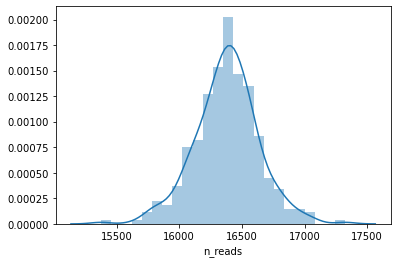

In [14]:
figure_legend("Figure 1","Library size distribution")
sns.distplot(df_library_size["n_reads"]); plt.show()

Two versions of the dataset are normalized: one with just the `top_n_genes` most variable genes and one with all genes. The former will be used to compute clusters after dimensionality reduction, and the latter to compute the characteristic direction (up or down) of each gene in a cluster. 

In [15]:
# Normalization

# maintain the unfiltered dataset to compute characteristic directions later
df_data_norm_all_genes = df_data.copy()

# take top_n_genes most variable rows
df_data_norm = filter_by_var(df_data,top_n = top_n_genes)

# compute log normalization of matrix
df_data_norm = log2_normalize(df_data_norm)
df_data_norm_all_genes = log2_normalize(df_data_norm_all_genes)

# convert to zscores
df_data_norm = zscore_normalize(df_data_norm)
df_data_norm_all_genes = zscore_normalize(df_data_norm_all_genes)

In [16]:
print("Normalized dataset with all genes has shape ",df_data_norm_all_genes.shape)
print(f"Normalized dataset with {top_n_genes} most variable genes has shape ", df_data_norm.shape)

Normalized dataset with all genes has shape  (18497, 328)
Normalized dataset with 2500 most variable genes has shape  (2500, 328)


In [17]:
figure_legend("Table 5","Normalized RNA-seq data", "Counts are filtered for the <i>top_n_genes</i> most variable genes. A log transform and normalization is performed on the resultitng dataset, which is then converted to z-scores.")
display(df_data_norm)

GTEX-111CU-0526-SM-5EGHK  GTEX-111YS-1226-SM-5EGGJ  \
symbol                                                       
PNLIP                   4.942540                  6.400434   
PRSS2                   6.887148                  5.825952   
PRSS1                   5.695414                  6.704531   
CPA1                    5.819542                  6.532914   
REG1A                   6.235750                  5.179841   
...                          ...                       ...   
MECOM                  -0.502143                 -0.570456   
MYADM                  -0.764615                 -1.063718   
MPZL1                  -0.536909                 -0.874477   
FBN1                   -0.994407                 -1.874510   
HCLS1                  -2.078516                 -1.843505   

        GTEX-1122O-0726-SM-5GIEV  GTEX-1128S-0826-SM-5GZZI  \
symbol                                                       
PNLIP                   5.187056                  4.129073   
PRSS2                   6.165085                  5.787735   
PRSS1                   5.932230                  4.952622   
CPA1                    5.900427                  5.261777   
REG1A                   4.971648                  5.766310   
...                          ...                       ...   
MECOM                  -0.710258                 -0.127428   
MYADM                  -0.578879                 -1.303970   
MPZL1                  -0.780120                 -0.628344   
FBN1                   -1.480364                 -2.417895   
HCLS1                  -1.793010                 -2.491401   

        GTEX-117YX-0226-SM-5EGH6  GTEX-11DXX-0926-SM-5H112  \
symbol                                                       
PNLIP                   5.920336                  5.591929   
PRSS2                   6.703342                  6.162056   
PRSS1                   6.435828                  5.908703   
CPA1                    6.321544                  5.950777   
REG1A                   6.071215                  4.955064   
...                          ...                       ...   
MECOM                  -0.864783                 -0.449651   
MYADM                  -0.237172                 -0.788122   
MPZL1                  -0.842054                 -0.491124   
FBN1                   -1.303551                 -1.435959   
HCLS1                  -1.299090                 -1.857426   

        GTEX-11EQ9-1026-SM-5H134  GTEX-11GSP-0426-SM-5A5KX  \
symbol                                                       
PNLIP                   5.406078                  6.684236   
PRSS2                   6.971878                  5.938313   
PRSS1                   6.226987                  6.695714   
CPA1                    6.438118                  6.267666   
REG1A                   5.266622                  3.930562   
...                          ...                       ...   
MECOM                  -0.347143                 -0.506419   
MYADM                  -1.085253                 -1.085993   
MPZL1                  -0.704034                 -0.817780   
FBN1                   -1.847000                 -2.035394   
HCLS1                  -1.714634                 -2.497074   

        GTEX-11I78-0626-SM-5A5LZ  GTEX-11LCK-0226-SM-5A5M6  ...  \
symbol                                                      ...   
PNLIP                   6.403261                  4.592226  ...   
PRSS2                   6.595853                  6.170192  ...   
PRSS1                   6.744120                  5.195385  ...   
CPA1                    6.829517                  5.756090  ...   
REG1A                   4.589119                  5.714014  ...   
...                          ...                       ...  ...   
MECOM                  -0.512936                 -0.339770  ...   
MYADM                  -0.880877                 -1.171967  ...   
MPZL1                  -0.592952                 -0.759833  ...   
FBN1                   -1.100344           

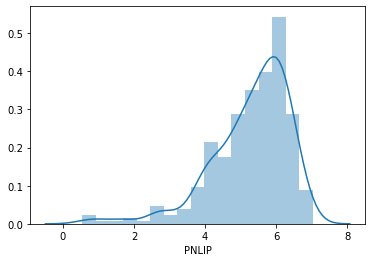

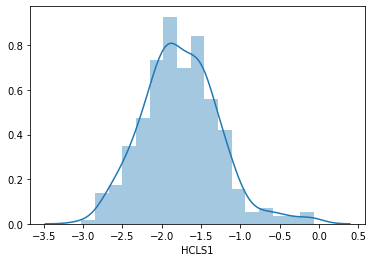

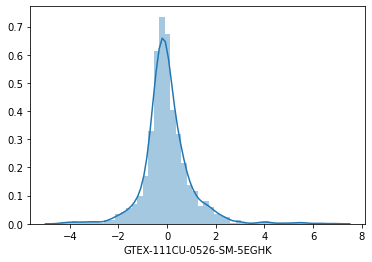

In [18]:
# plot the first gene distribution
gene = df_data_norm.index.values[0]
sns.distplot(df_data_norm.iloc[0, :]); plt.show()
figure_legend("Figure 2",f"Sample gene expression distibution for {gene}", f"In this dataset, {gene} is the most variably expressed across all samples.")

# plot the last gene distribution
gene = df_data_norm.index.values[-1]
sns.distplot(df_data_norm.iloc[-1, :]); plt.show()
figure_legend("Figure 3",f"Sample gene expression distibution for {gene}", f"In this dataset, {gene} is the least variably expressed across all samples among the 2500 most variably expressed genes.")

# plot a single RNA seq profile distribution
sns.distplot(df_data_norm.iloc[:, 0]); plt.show()
figure_legend("Figure 4","Sample individual RNA-seq profile distribution")

## 3. Reduce Data Dimensionality

Now that the data has been loaded and normalized, the most variable genes across the dataset can be identified and visualized with hierachical clustering and heatmaps. Dimensionality reduction facilitates the differentiation of the data in a more efficient manner by reducing the number of attributes to be considered. 

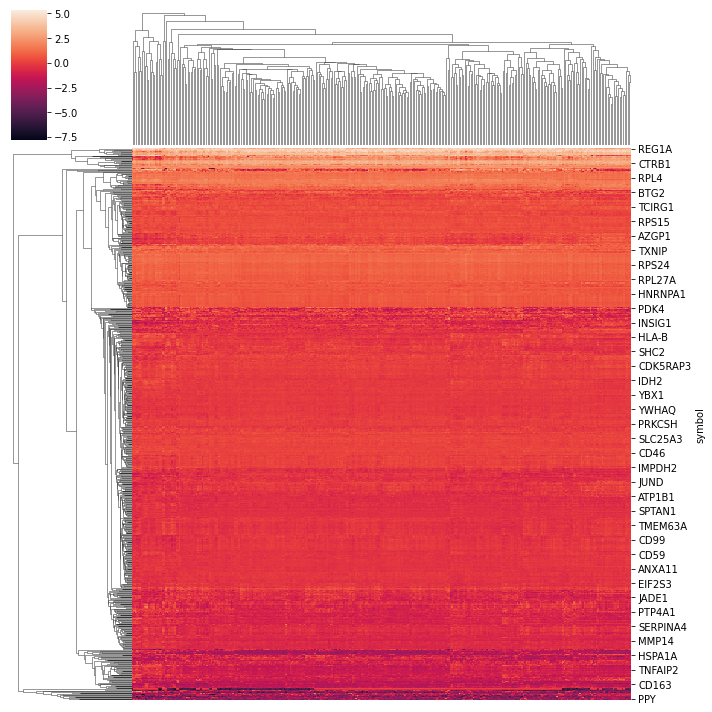

In [19]:
# Normalization
# take top 800 most variable rows

# the "i" in the variable here stands for "initial", since we'll do a different method 
# for selecting genes for a heatmap later
df_data_norm_heatmap_i = filter_by_var(df_data,top_n=800)

# compute log normalization of matrix
df_data_norm_heatmap_i = log2_normalize(df_data_norm_heatmap_i)

# convert to zscores
df_data_norm_heatmap_i = zscore_normalize(df_data_norm_heatmap_i) 

# Plot heatmap
sns.clustermap(df_data_norm_heatmap_i,xticklabels=False); plt.show()
figure_legend("Figure 5","Heatmap of normalized expression for top 800 most variable genes", "This initial heatmap considers only the top most variable genes across the entire dataset, rather than the most differentially expressed genes among potential clusters. As such, there may seem to be a lot of noise preventing us from seeing clear clusters. This will be amended in a later heatmap.")


### 4a. Principle Component Analysis 
PCA is used first to reduce the dimensionality of the dataset, while still maintaining most of the variability.

In [20]:
# PCA
data_norm_pca = PCA(
  random_state=42,
)

data_norm_pca.fit(df_data_norm.values.T)

df_data_norm_pca = pd.DataFrame(
    data_norm_pca.transform(df_data_norm.values.T),
    index=df_data_norm.T.index
)

df_data_norm_pca.columns = [
    f'PCA-{c}' # ({r:.3f})'
    for c, r in zip(df_data_norm_pca.columns, data_norm_pca.explained_variance_ratio_)
]

df_data_norm_pca.index.name = "sample_id"

In [21]:
figure_legend("Table 6","Principle components of RNA-seq data", "The top principle components are the projections of each datapoint onto the axes along which there is the most variation in the dataset.")
display(df_data_norm_pca.head())

PCA-0     PCA-1     PCA-2      PCA-3     PCA-4  \
sample_id                                                                      
GTEX-111CU-0526-SM-5EGHK  -0.350049 -8.273109 -3.836218  -0.952805 -2.976887   
GTEX-111YS-1226-SM-5EGGJ  -7.994692 -7.846734 -5.305073   1.274527  0.442721   
GTEX-1122O-0726-SM-5GIEV  -7.742031 -7.215764  6.104552   0.422725 -0.061877   
GTEX-1128S-0826-SM-5GZZI  10.199253  0.952881  5.974276  12.781264 -1.076329   
GTEX-117YX-0226-SM-5EGH6   4.968264 -1.846034 -3.132782  -3.970261 -3.729922   

                             PCA-5     PCA-6     PCA-7     PCA-8     PCA-9  \
sample_id                                                                    
GTEX-111CU-0526-SM-5EGHK  1.822660 -5.776062  2.404778  1.102860 -2.840214   
GTEX-111YS-1226-SM-5EGGJ  0.207426 -1.037894 -1.425603 -2.207448 -1.256135   
GTEX-1122O-0726-SM-5GIEV -2.233763 -1.317011 -0.295477 -4.805631 -3.065579   
GTEX-1128S-0826-SM-5GZZI  0.751315  0.364087  0.786424  0.727562  9.564251   
GTEX-117YX-0226-SM-5EGH6  2.432521  8.921774 -5.988966  0.924536  0.696622   

                          ...   PCA-318   PCA-319   PCA-320   PCA-321  \
sample_id                 ...                                           
GTEX-111CU-0526-SM-5EGHK  ...  0.185081 -0.024585 -0.234347 -0.311813   
GTEX-111YS-1226-SM-5EGGJ  ...  0.452033 -0.364617 -0.011656  0.019476   
GTEX-1122O-0726-SM-5GIEV  ...  0.160339  0.087302  0.665720 -0.001827   
GTEX-1128S-0826-SM-5GZZI  ...  0.000585  0.069698 -0.109466 -0.003776   
GTEX-117YX-0226-SM-5EGH6  ...  0.291332 -0.191489 -0.099724  0.003574   

                           PCA-322   PCA-323   PCA-324   PCA-325   PCA-326  \
sample_id                                                                    
GTEX-111CU-0526-SM-5EGHK  0.156172  0.269441  0.168482  0.034190  0.071533   
GTEX-111YS-1226-SM-5EGGJ -0.343602 -0.106125  0.484989  0.143493  0.066825   
GTEX-1122O-0726-SM-5GIEV  0.457786 -0.070354  0.272089  0.105953 -0.047582   
GTEX-1128S-0826-SM-5GZZI -0.094929  0.135278  0.098436 -0.083394 -0.073366   
GTEX-117YX-0226-SM-5EGH6 -0.058357  0.019814  0.160227  0.038511 -0.123025   

                               PCA-327  
sample_id                               
GTEX-111CU-0526-SM-5EGHK  1.999789e-14  
GTEX-111YS-1226-SM-5EGGJ  1.959544e-14  
GTEX-1122O-0726-SM-5GIEV  1.998401e-14  
GTEX-1128S-0826-SM-5GZZI  2.381428e-14  
GTEX-117YX-0226-SM-5EGH6  1.928666e-14  

[5 rows x 328 columns]

The data can now be plotted with the [React-Scatter-Board](https://github.com/MaayanLab/react-scatter-board) package.

In [22]:
pca_data = merge(
        df_data_norm_pca[["PCA-0", "PCA-1"]],
        df_library_size,
        df_metadata
      )

pca_data = pca_data.rename(columns={'PCA-0': 'x', 'PCA-1': 'y'})
pca_data['label'] = pca_data.index

In [23]:
pca_scatter_data = pca_data.to_dict('records')

ScatterBoard(
    id='pca-scatterboard',
    is3d=False,
    data=pca_scatter_data,
    shapeKey='age',
    colorKey='sex',
    labelKeys=['label'],
    searchKeys=['label','path_notes', 'dthhrdy', 'bss_site'],
    width=800,
    height=600
)


**Figure 6:** *First two PCA components of RNA-seq data.* Points are labeled by Sample ID and can be color- or shape-coded by any of the metadata categories using the dropdown menus. Points can also be isolated by searching by sample ID, pathology notes, Hardy Scale classification, and BSS site.

### 4b. Uniform Manifold Approximation and Projection

The dimensionality of the dataset is further reduced by performing UMAP on the data projected onto the first `n_pca_components` PCA components.

In [24]:
# UMAP
data_norm_umap = UMAP(
  random_state=42,
  n_components=2,
  n_neighbors=min(n_neighbors, df_data_norm_pca.shape[0]-1),
  metric='cosine',
  min_dist=min_cluster_dist,
)

# use top n_pca_components components of PCA
n_pca_components = min(n_pca_components,df_data_norm_pca.shape[1])
data_norm_umap.fit(df_data_norm_pca.iloc[:, :n_pca_components].values)

df_data_norm_umap = pd.DataFrame(
  data_norm_umap.transform(df_data_norm_pca.iloc[:, :n_pca_components].values),
  columns=['UMAP-0', 'UMAP-1'],
  index=df_data_norm_pca.index,
)

In [25]:
# project data onto its first 2 UMAP components for visualization
umap_data = merge(
        df_data_norm_umap[["UMAP-0", "UMAP-1"]],
        df_library_size,
        df_metadata
      )

umap_data = umap_data.rename(columns={'UMAP-0': 'x', 'UMAP-1': 'y'})
umap_data['label'] = umap_data.index

In [26]:
umap_scatter_data = umap_data.to_dict('records')

ScatterBoard(
    id='umap-scatterboard',
    is3d=False,
    data=umap_scatter_data,
    shapeKey='age',
    colorKey='sex',
    labelKeys=['label'],
    searchKeys=['label','path_notes', 'dthhrdy', 'bss_site'],
    width=800,
    height=600
)

**Figure 7:** *First two UMAP components of RNA-seq data.* The datapoints are again labeled by sample ID, and can be color- or shape-coded by any of the metadata categories using the dropdown menu. Points can also be isolated by searching by sample ID, pathology notes, Hardy Scale classification, and BSS site.

## 5. Clustering

The first two UMAP components will be used from here on out. 

To compute sample clusters, the k-means method is used. The total number of clusters must be determined, by first testing a range for the number of total clusters, and then computing silhouette scores, which are a measure of how similar an entry is to its own cluster versus other clusters. The goal is to maximize both the similarity within a cluster and the differences between clusters, so the ideal number of clusters is that which produces the highest silhouette score.

Here, the selection of $k$ is modified slightly to preserve nuances in the data by prioritizing more clusters over fewer. A modified silhouette score is also calculated, which takes into account the number of clusters $k$; each original score is bumped by a factor linear with respect to $k$. 

In [27]:
def plot_silhouette_analysis(n_clusters, data, cluster_labels, avg_score, sample_values, centers):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for k-means clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

In [28]:
silhouette_scores = []

# Set max clusters as a function of the sample size and the user-selected option
max_clusters = math.ceil(df_data_norm_umap.shape[0]**0.5)
if (max_clusters_calculation == "root/2"):
    max_clusters = int(math.ceil(max_clusters/2))


def calc_weighted_score(silhouette_score, k, max_k):
    return silhouette_avg*0.7 + k/max_k*0.3

cluster_range = range(2, (max(max_clusters, 3)))
for n in cluster_range:
    X = df_data_norm_umap.values
    clusterer = KMeans(n_clusters=n, random_state=42).fit(X)
    y_pred = clusterer.predict(X)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, y_pred, metric='cosine')
    
    # Compute a weighted score that rewards higher numbers of clusters
    weighted_score = calc_weighted_score(silhouette_avg, n, max_clusters)
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, y_pred)

    silhouette_scores.append({
        "N Clusters": n,
        "Silhouette Score": silhouette_avg,
        "Weighted Score": weighted_score
    })
    
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    
    # Plot the analysis for this number of clusters
    #plot_silhouette_analysis(n, X, y_pred, silhouette_avg, sample_silhouette_values, centers)

If using the "second derivative method" for ideal $k$ calculation, estimates of the second derivatives at each possible point can be computed to see if there are local maxima that may present better values of $k$ than the silhouette scores suggest. If such maxima exist, the value of $k$ that presents the most negative approximated second derivative (meaning the plot of scores is most concave *down* at this value of $k$) is chosen. 

To calculate the second derivatives, the following approximation is used:

$$ f''(x) \approx \frac{f(x+h) - 2f(x) + f(x-h)}{h^2}$$

where, in this case, $h = 1$.

In [29]:
points = {}
threshold = 0.3
score_type = "Silhouette Score"
if use_weighted_silhouette_score:
    score_type = "Weighted Score"
    
for s in silhouette_scores:
    points[s["N Clusters"]] = s[score_type]

# No local maxima - resort to previous method of best score calculation
k = None

if (use_second_deriv_method):
    local_maxima = []
    # Collect all local maxima
    if len(cluster_range)>2:
        calc_range = range(cluster_range[1], cluster_range[-2])
        for n in calc_range:
            if points[n] > threshold and points[n-1] < points[n] and points[n+1] < points[n]:
                local_maxima.append(n)
        
    elif len(cluster_range)>1:
        calc_range = cluster_range
        if (points[cluster_range[1]] > threshold and points[cluster_range[0]] < points[cluster_range[1]]):
            local_maxima.append(cluster_range[1])
        if (points[cluster-range[0]] > threshold and points[cluster_range[1]] < points[cluster_range[0]]):
            local_maxima.append(cluster_range[0])
        
    if len(local_maxima)>0:
        print("K values for local maxima and positive silhouette score: ", local_maxima)
    else:    
        print("No local maxima with positive silhouette scores found")
        

    # Otherwise, calculate which of the local max is most concave down (i.e. largest second derivative)
    if len(local_maxima) > 0:
        running_max = 0
        for maxima in local_maxima:
            # approximate the second derivative, with step size = 1
            second_deriv = points[maxima + 1] -  2*points[maxima] + points[maxima-1]
            if second_deriv < running_max:
                running_max = second_deriv
                k = maxima

K values for local maxima and positive silhouette score:  [6]


In [30]:
silhouette_scores = pd.DataFrame(silhouette_scores)

figure_legend("Table 7", "Silhouette scores by number of clusters", "Values are sorted by the highest silhouette score.")
display(silhouette_scores.sort_values(["Silhouette Score", "Weighted Score"], ascending=False).reset_index().head())

best_score = silhouette_scores.sort_values('Silhouette Score').iloc[-1].to_dict()
best_weighted = silhouette_scores.sort_values('Weighted Score').iloc[-1].to_dict()

best = {"Silhouette Score": best_score, "Weighted Score": best_weighted}

index  N Clusters  Silhouette Score  Weighted Score
0      0           2          0.772276        0.600593
1      1           3          0.728718        0.600103
2      2           4          0.548482        0.503937
3      4           6          0.509317        0.536522
4      3           5          0.509273        0.506491

In [31]:
if not k:
    k = int(best["Silhouette Score"]["N Clusters"])
    if (use_weighted_silhouette_score):
        k = int(best["Weighted Score"]["N Clusters"])
    
print(f"Ideal k: {k} clusters")

Ideal k: 6 clusters


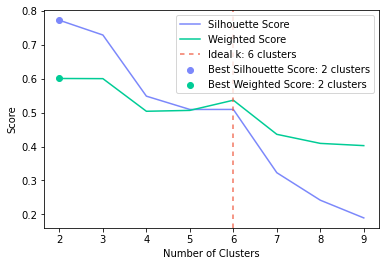

In [32]:
# plot both the uneqeighted and weighted scores as a function of # of clusters
colors = {"Silhouette Score": "#7C88FB", "Weighted Score": "#00CC96"}

for score_type in ['Silhouette Score', 'Weighted Score']:
    plt.plot(silhouette_scores['N Clusters'], silhouette_scores[score_type], label=score_type,color=colors[score_type])
    plt.scatter([best[score_type]['N Clusters']], [best[score_type][score_type]], label=f"Best {score_type}: {int(best[score_type]['N Clusters'])} clusters",color=colors[score_type])
plt.axvline(k, label = f"Ideal k: {k} clusters", color ="#EF553B", alpha=0.8,dashes=(3,3))
plt.legend()
plt.ylabel('Score')
plt.xlabel('Number of Clusters')
plt.show()
figure_legend("Figure 8", "Cluster size selection", "The dotted line indicates the value of the 'ideal' <i>k</i> as chosen by the selected scoring method. This value will be used in subsequent clustering.")

In [33]:
# Compute the k-means dataframe using the ideal number of clusters
km = KMeans(n_clusters=k, random_state=42)
km_clusters = km.fit_predict(df_data_norm_umap.values)

df_data_norm_km = pd.DataFrame({
'Cluster': [
    str(c)
    for c in km_clusters
]}, index=df_data_norm_umap.index)


print(f'Computed {len(df_data_norm_km["Cluster"].unique())} clusters')

Computed 6 clusters


In [34]:
figure_legend("Table 8", "Clusters of first five samples.")
df_data_norm_km.head()

Cluster
sample_id                       
GTEX-111CU-0526-SM-5EGHK       0
GTEX-111YS-1226-SM-5EGGJ       0
GTEX-1122O-0726-SM-5GIEV       3
GTEX-1128S-0826-SM-5GZZI       1
GTEX-117YX-0226-SM-5EGH6       4

In [35]:
# Map each cluster to a color for later plots
clusters = df_data_norm_km["Cluster"].unique()
#plotly_colors = px.colors.qualitative.Plotly
plotly_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']
cluster_colors = {}
i = 0
for c in clusters:
    cluster_colors[c] = plotly_colors[i % len(plotly_colors)]
    i += 1

def cluster_heading(cluster):
    display(HTML(f'''
    <center>
    <div style='background-color:{cluster_colors[cluster] + '98'};
        width:100%;height:3rem;display:flex;align-items:center;
        justify-content:center;color:white;font-size:2rem'>
        <center>Cluster {cluster}</center>
    </div>
    </center>'''))
    

Next, the differential expression for each cluster is computed. The <a href="http://www.maayanlab.net/CD/">Characteristic Direction method</a> is used for identifying differentially expressed genes among the different clusters.

In [36]:
# Get differential expression for each cluster, using the dataset containing all genes
diff_expr = {}
for cluster, samples in df_data_norm_km.groupby('Cluster'):
    diff_expr[f"Cluster {cluster} CD"] = characteristic_direction(
        # expression outside of this cluster
        df_data_norm_all_genes.loc[:, df_data_norm_all_genes.columns.difference(samples.index)],
        # expression in this cluster
        df_data_norm_all_genes.loc[:, samples.index],
      )['CD-coefficient']

df_diff_expr = pd.DataFrame(diff_expr)
df_diff_expr = df_diff_expr.sort_values(by='Cluster 0 CD',ascending=True)
df_diff_expr['Symbol'] = df_diff_expr.index.values

In [37]:
figure_legend("Table 9", "Differential expression of genes by cluster", "By default, the top 5 most differentially expressed genes are shown, along with the corresponding characteristic directions for each cluster.")
display(df_diff_expr.head())

Cluster 0 CD  Cluster 1 CD  Cluster 2 CD  Cluster 3 CD  \
IFITM5       -0.054179     -0.022183      0.027516      0.048772   
SLC22A31     -0.053378     -0.012292      0.052336      0.035634   
TRPC5        -0.046820     -0.019100      0.028897      0.045275   
CYP2C9       -0.044079     -0.036611      0.024437      0.036728   
CDH15        -0.043210     -0.038218      0.021630      0.022411   

          Cluster 4 CD  Cluster 5 CD    Symbol  
IFITM5        0.035381     -0.038259    IFITM5  
SLC22A31      0.008640     -0.027116  SLC22A31  
TRPC5         0.023725     -0.033885     TRPC5  
CYP2C9        0.027277     -0.006790    CYP2C9  
CDH15         0.027346      0.015210     CDH15

Logistic regression is performed for each metadata category to determine which categories most accurately predict cluster designations for each data point. ROC curves are also plotted for categories with top five highest AUC scores.

In [38]:
# LR
aucs = {}
num_rocs_plotted = 0
rocs = {}

for cluster, samples in df_data_norm_km.groupby('Cluster'): 
    aucs[cluster] = {}
    rocs[cluster] = []

    for feature in features:
        lr = LogisticRegression()
        X = df_metadata.copy()
        X = X[feature]
        X = pd.merge(X, df_data_norm_km, left_index = True, right_index = True)

        # drop NAs, and move on if dataset is empty
        X.replace("not reported", None)
        X = X.dropna()
        if (X.shape[0] == 0): continue

        cluster_data = X["Cluster"]
        X = X.drop(columns= ["Cluster"])

        # one-hot encode non numerical data
        if (not isinstance(X[feature][0], (int, float, complex))):
            X = pd.get_dummies(X[feature], prefix=feature)

        y_true = (cluster_data == cluster)
        
        if (len(y_true.unique()) < 2): # if there is only one class in the dataset
            print(f"Not enough data to classify cluster {cluster} based on category {feature}")
            aucs[cluster][feature] = np.nan
            continue 
                  
        lr.fit(X, y_true)

        y_score = lr.predict_proba(X)[:, 1]
        auc_score = roc_auc_score(y_true, y_score)
        aucs[cluster][feature] = auc_score
        
        # save the ROCs
       
        rocs[cluster].append({"auc":auc_score, "lr": lr, "X": X, "y_true":y_true, "title": f'Predictions of cluster {cluster} by category {feature}'})
        
df_cluster_aucs = pd.DataFrame(aucs)
df_cluster_aucs.index.name="Category"

# sort features by avg AUC across all clusters
df_cluster_aucs["avg"] = [ np.mean(df_cluster_aucs.T[f]) for f in df_cluster_aucs.index.values ]
df_cluster_aucs = df_cluster_aucs.sort_values(by = "avg", ascending=False)
df_cluster_aucs = df_cluster_aucs.drop(columns = "avg")

cols = [('Cluster', col) for col in df_cluster_aucs.columns ]
df_cluster_aucs.columns = pd.MultiIndex.from_tuples(cols)

In [39]:
figure_legend("Table 10", "Average AUC scores for top predictive metadata categories, by cluster", "Scores for the top 10 metadata categories for predicting clusters, as determined by the average AUC score across all clusters, are shown. Higher AUC scores correspond to better classifiers for distinguishing whether or not a datapoint belongs to a certain cluster.")
display(df_cluster_aucs.head(10))

Cluster                                                  
                         0         1         2         3         4         5
Category                                                                    
path_notes        0.999712  0.999783  1.000000  0.999880  0.999896  0.993377
iso_batch_id      0.955651  0.978060  0.956753  0.960497  0.962824  0.985290
iso_batch_date    0.937464  0.977137  0.948736  0.948607  0.948622  0.971854
gtype_batch_id    0.878269  0.947690  0.900395  0.896825  0.874656  0.939113
gtype_batch_date  0.835014  0.929653  0.856027  0.872024  0.838704  0.926271
sex               0.750000  0.848485  0.714539  0.890566  0.731516  0.842715
frag_len_std      0.586513  0.593896  0.555928  0.521414  0.676405  0.764200
dthhrdy           0.570176  0.615673  0.602490  0.600000  0.548063  0.719689
exp_prof_eff      0.550548  0.676333  0.522587  0.623839  0.647556  0.632068
intron_rate       0.568662  0.701097  0.496608  0.626355  0.634921  0.608635

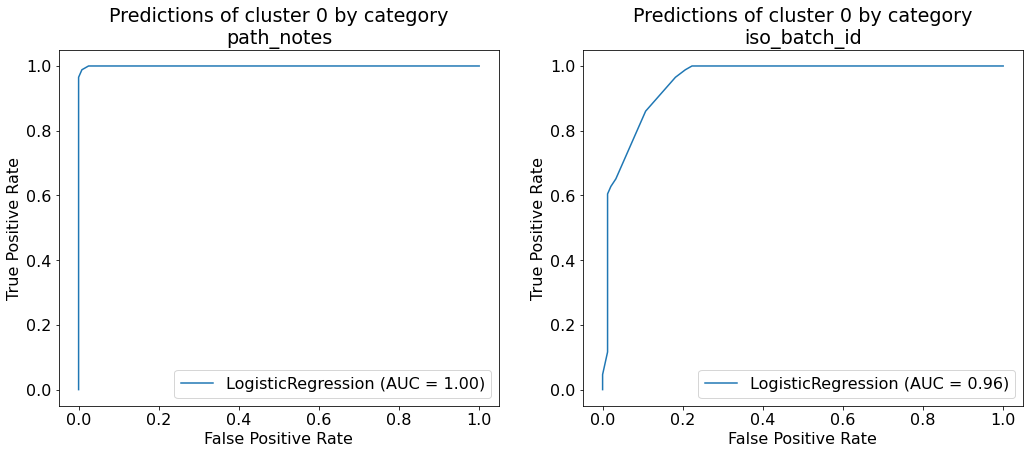

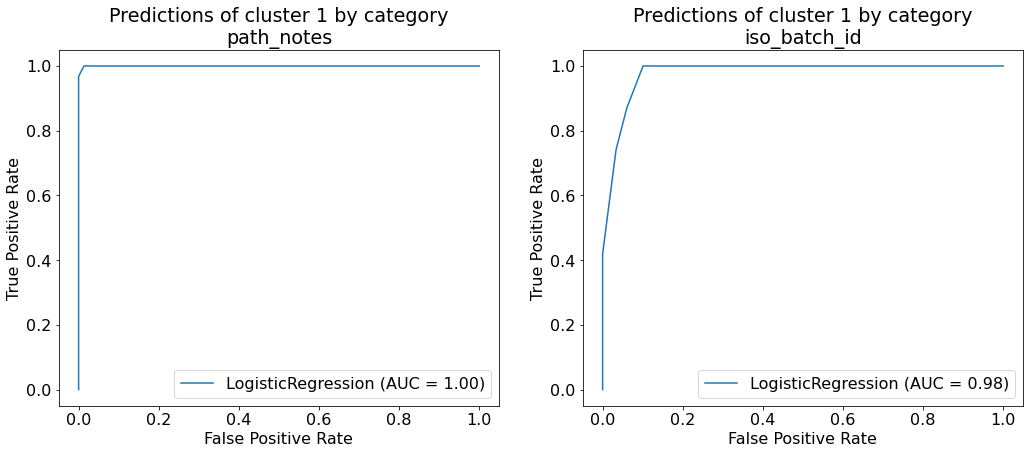

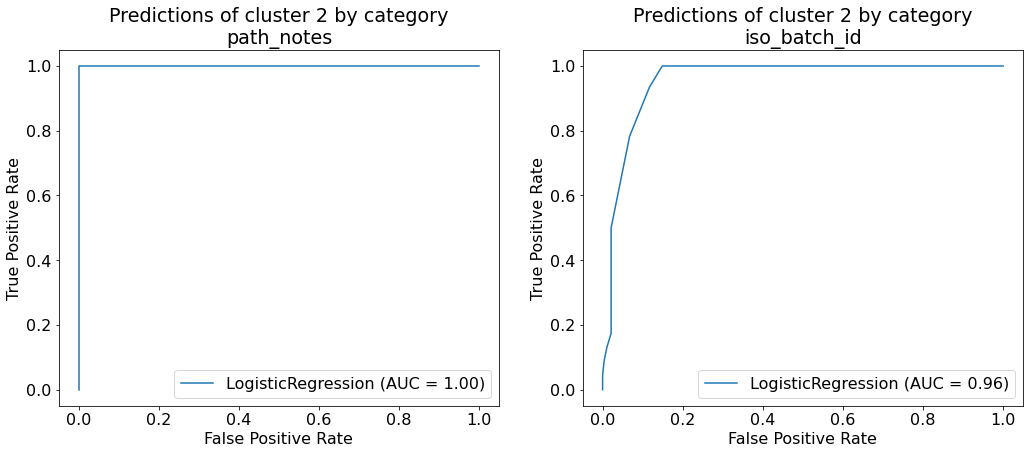

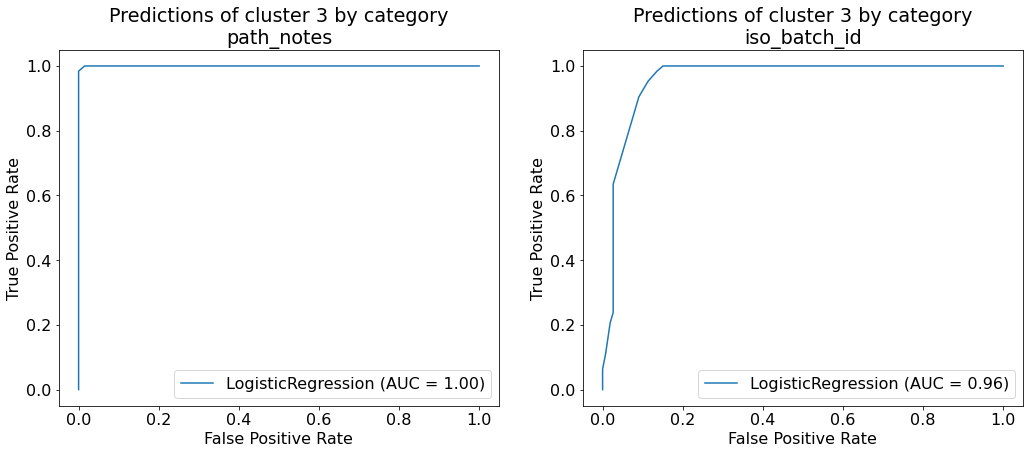

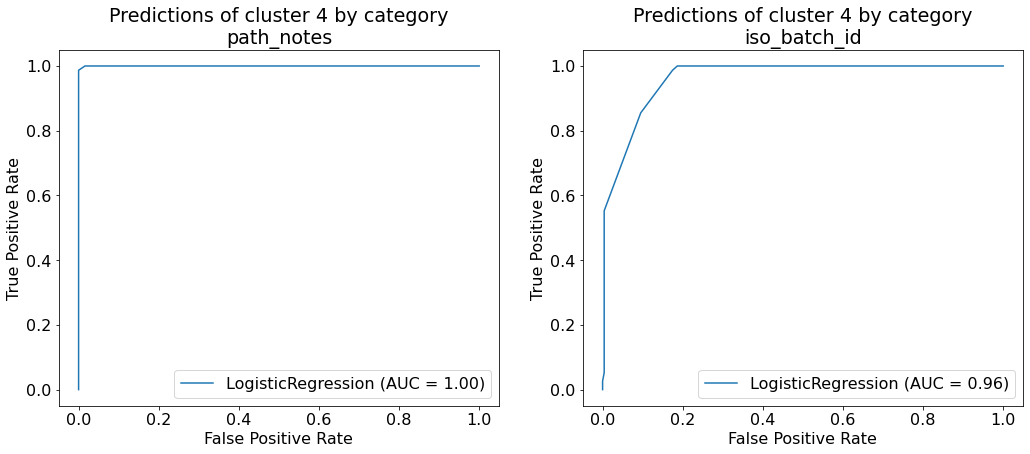

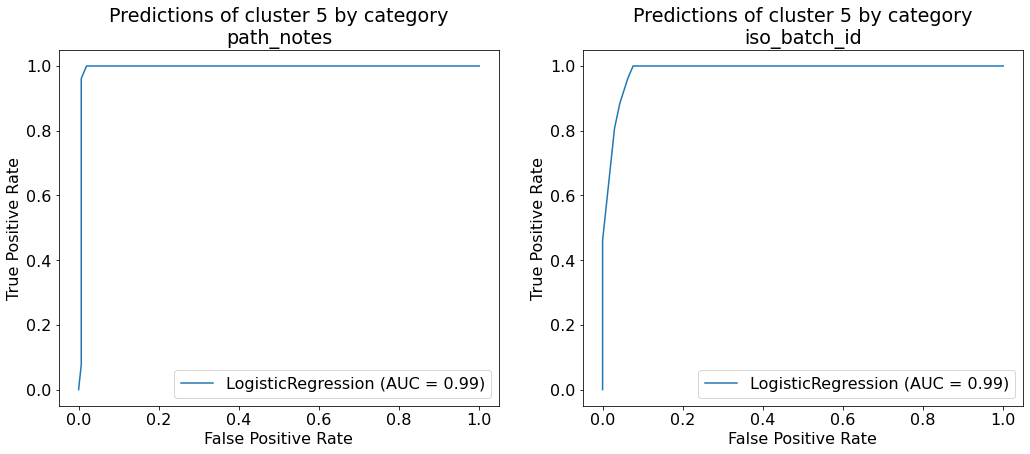

In [40]:
# plot top 2 (or however many exist) ROCs for each cluster
matplotlib.rc('font', size=16)

for cluster, plots in rocs.items():
    plots.sort(reverse=True, key=lambda x: x["auc"])
    cluster_heading(cluster)
    
    if len(plots) < 2:
        best_rocs = plots
    else:
        best_rocs = plots[:2]

    num_plots = len(best_rocs)
    figure,axes = plt.subplots(int(math.ceil(num_plots / 2.)), 2, figsize=(15,(len(best_rocs)*3.5)))
    
    axes = axes.flatten()
    for i in range(len(axes)):
        if i >= len(best_rocs):
            axes[i].remove()
        else:
            plot = best_rocs[i]
            fig = metrics.plot_roc_curve(plot["lr"], plot["X"], plot["y_true"], ax=axes[i])

            axes[i].set_title('\n'.join(wrap(plot["title"], 40)))

    figure.tight_layout(pad=2)
    plt.show()
    
figure_legend("Figure 9", "ROCs for top cluster-predicting metadata categories")

matplotlib.rcdefaults()

## 6. Identify Up- and Down-Regulated Genes
Find the most up- and down-regulated genes for each cluster for visualization in heatmap, and for enrichment analysis. 

In [41]:
# Merge data
df_clustered_umap = pd.merge(left=df_data_norm_km, left_on="sample_id", right=df_data_norm_umap, right_on="sample_id")
df_clustered_pca = pd.merge(left=df_data_norm_km, left_on="sample_id", right=df_data_norm_pca, right_on="sample_id")

In [42]:
# Get top Genes for each cluster
top_genes = {}
all_top_genes = []
heatmap_top_n = min(heatmap_top_n, top_n_genes_enrichment)
for cluster in df_clustered_umap['Cluster'].unique():
    cd_col = f'Cluster {cluster} CD'
    if cd_col in df_diff_expr.columns:
        # top up genes
        up_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=False).iloc[:top_n_genes_enrichment].index, 'Symbol'].values
        # top down genes
        dn_genes = df_diff_expr.loc[df_diff_expr[cd_col].sort_values(ascending=True).iloc[:top_n_genes_enrichment].index, 'Symbol'].values
    else:
        raise Exception('Cant find col for cluster')
    all_top_genes.append(up_genes[:heatmap_top_n])
    all_top_genes.append(dn_genes[:heatmap_top_n])
    # save results
    top_genes[cluster] = (up_genes, dn_genes)
all_top_genes = [item for sublist in all_top_genes for item in sublist]  # flatten all genes to one list

Data corresponding to only the `heatmap_top_n` up- and down-regulated genes for each cluster is selected for visualization in a heatmap, with log-transformation and normalization proceeding as before. 

In [43]:
df_data_norm_heatmap_f = df_data.loc[all_top_genes, :]

# compute log normalization of matrix
df_data_norm_heatmap_f = log2_normalize(df_data_norm_heatmap_f)

# convert to zscores
df_data_norm_heatmap_f = zscore_normalize(df_data_norm_heatmap_f) 

# Plot heatmap
cases = df_data_norm_heatmap_f.columns
heatmap_cluster_colors = [ cluster_colors[x] for x in df_clustered_umap.loc[cases, :]["Cluster"] ]

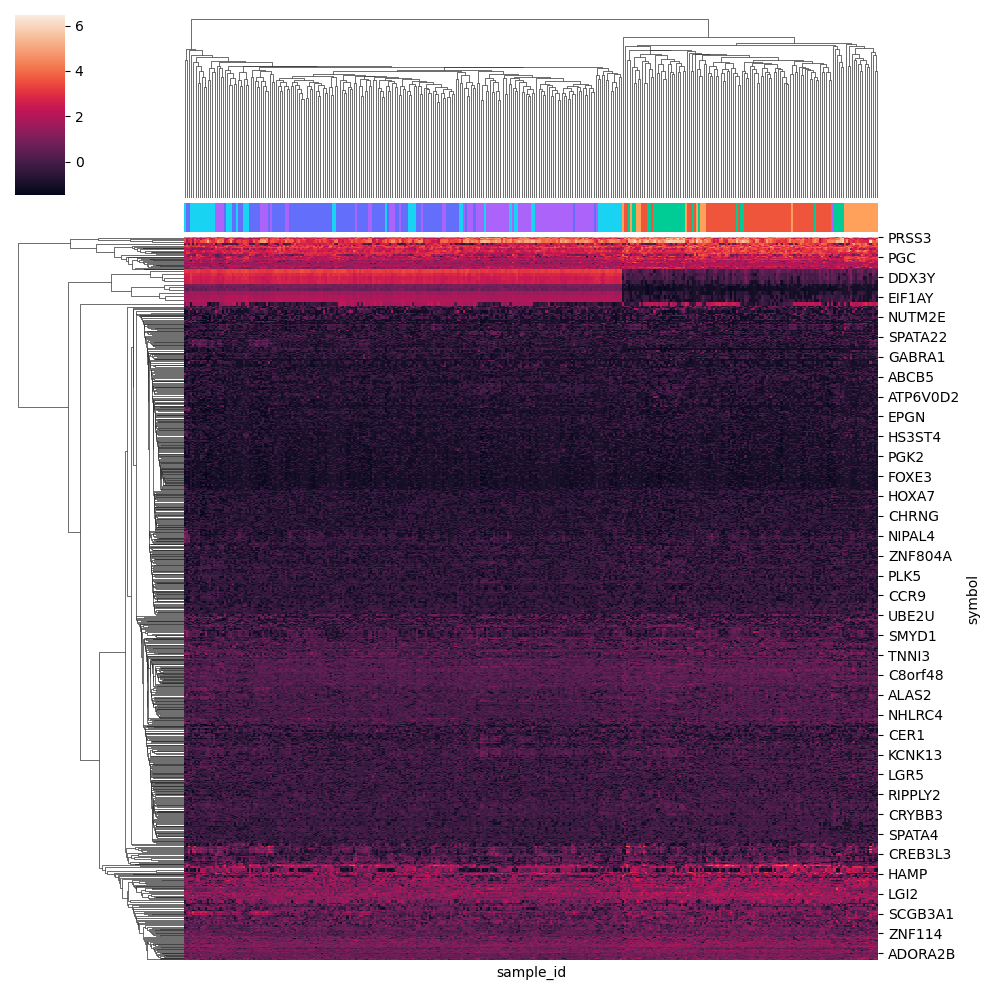

In [44]:
sns.clustermap(df_data_norm_heatmap_f,xticklabels=False,col_colors = heatmap_cluster_colors); plt.show()
figure_legend("Figure 10", "Heatmap of most differentially expressed genes", "Color coding along the top edge indicates cluster designation of the corresponding sample.")

##  7. Enrichment Analysis with Enrichr

Perform enrichment analysis for each cluster by querying the [Enrichr](https://maayanlab.cloud/Enrichr/) API. A link is provided to download the results. 

In [45]:
# Util functions
def enrichr_link_from_genes(genes, description='', enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    ''' Functional access to Enrichr API
    '''
    time.sleep(1)
    resp = requests.post(enrichr_link + '/addList', files={
    'list': (None, '\n'.join(genes)),
    'description': (None, description),
    })
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    # wait a tinybit before returning link (backoff)
    time.sleep(3)
    result = resp.json()
    return dict(result, link=enrichr_link + '/enrich?dataset=' + resp.json()['shortId'])

def enrichr_get_top_results(userListId, bg, enrichr_link='https://amp.pharm.mssm.edu/Enrichr'):
    time.sleep(1)
    resp = requests.get(enrichr_link + '/enrich?userListId={}&backgroundType={}'.format(userListId, bg))
    if resp.status_code != 200:
        raise Exception('Enrichr failed with status {}: {}'.format(
          resp.status_code,
          resp.text,
        ))
    time.sleep(3)
    return pd.DataFrame(resp.json()[bg], columns=['rank', 'term', 'pvalue', 'zscore', 'combinedscore', 'overlapping_genes', 'adjusted_pvalue', '', ''])

In [46]:
# Get Enrichr links for each cluster
enrichr_links = {}

for cluster, (up_genes, dn_genes) in top_genes.items():
    up_link, dn_link = None, None
    if up_genes.size:
        try:
            up_link = enrichr_link_from_genes(up_genes, f'cluster {cluster} up')
        except:
            print(f'Enrichr failed for cluster {cluster} up genes')
    else:
        print(f'cluster {cluster} up: empty')
    if dn_genes.size:
        try:
            dn_link = enrichr_link_from_genes(dn_genes, f'cluster {cluster} down')
        except:
            print(f'Enrichr failed for cluster {cluster} down genes')
    else:
        print(f'cluster {cluster} down: empty')
    enrichr_links[cluster] = (up_link, dn_link)

# Grab top results for each cluster
all_enrichr_results = []
for cluster, (up_link, dn_link) in enrichr_links.items():
    for link_type, link in [('up', up_link), ('down', dn_link)]:
        if link is None:
            continue
        for category, libraries in enrichr_libraries.items():
            for library in libraries:
                try:
                    results = enrichr_get_top_results(link['userListId'], library).sort_values('pvalue').iloc[:top_n_results]
                    results['link'] = link['link']
                    results['library'] = library
                    results['category'] = category
                    results['direction'] = link_type
                    results['cluster'] = cluster
                    all_enrichr_results.append(results)
                except:
                    print('{}: {} {} {} cluster {} failed, continuing'.format(link, library, category, link_type, cluster))

df_enrichr_results = pd.concat(all_enrichr_results).reset_index()

In [47]:
# Display a dataframe with clickable enrichr links
figure_legend("Table 11","Enrichment analysis results from Enrichr", "Results are grouped by expression direction (up/down) and gene set library. Within groups, results are sorted by lowest p-value (highest rank) first.")
df_clickable = df_enrichr_results.copy()
df_clickable['link'] = df_clickable["link"].apply(make_clickable)
table_html = df_clickable.to_html(escape=False)
display(HTML(f'<div style="max-height: 250px; overflow-y: auto; margin-bottom: 25px;">{table_html}</div>'))
download_button(df_enrichr_results.to_csv(), 'Download Enrichr results', 'Enrichr results.csv')

### 7a. Barplots
Horizontal barplots are used to display the top Enrichr results for each cluster, by library and characteristic expression direction.

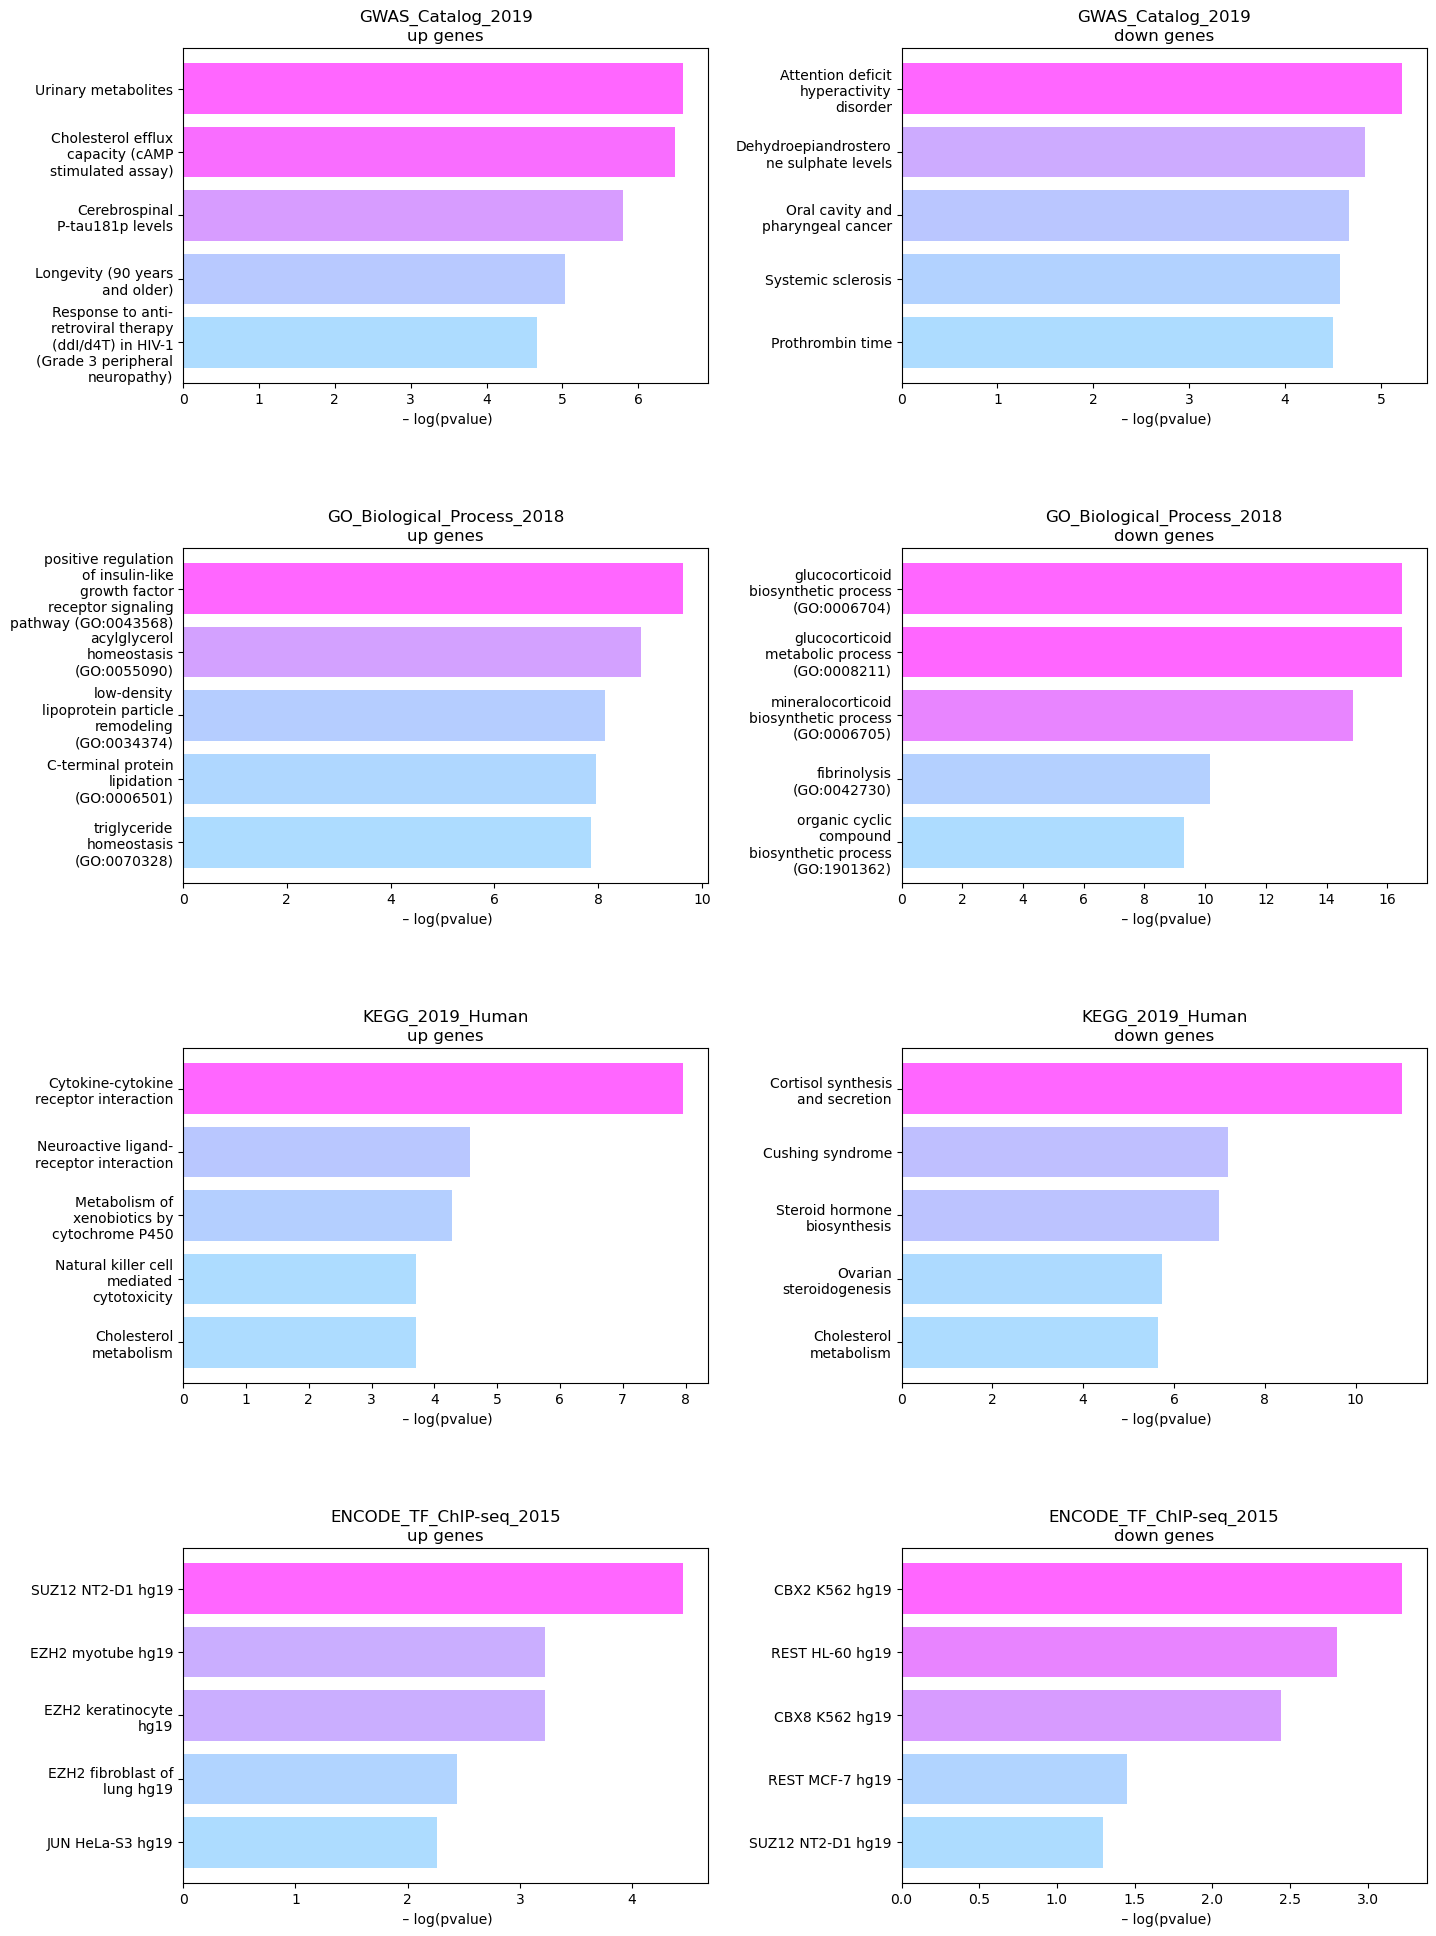

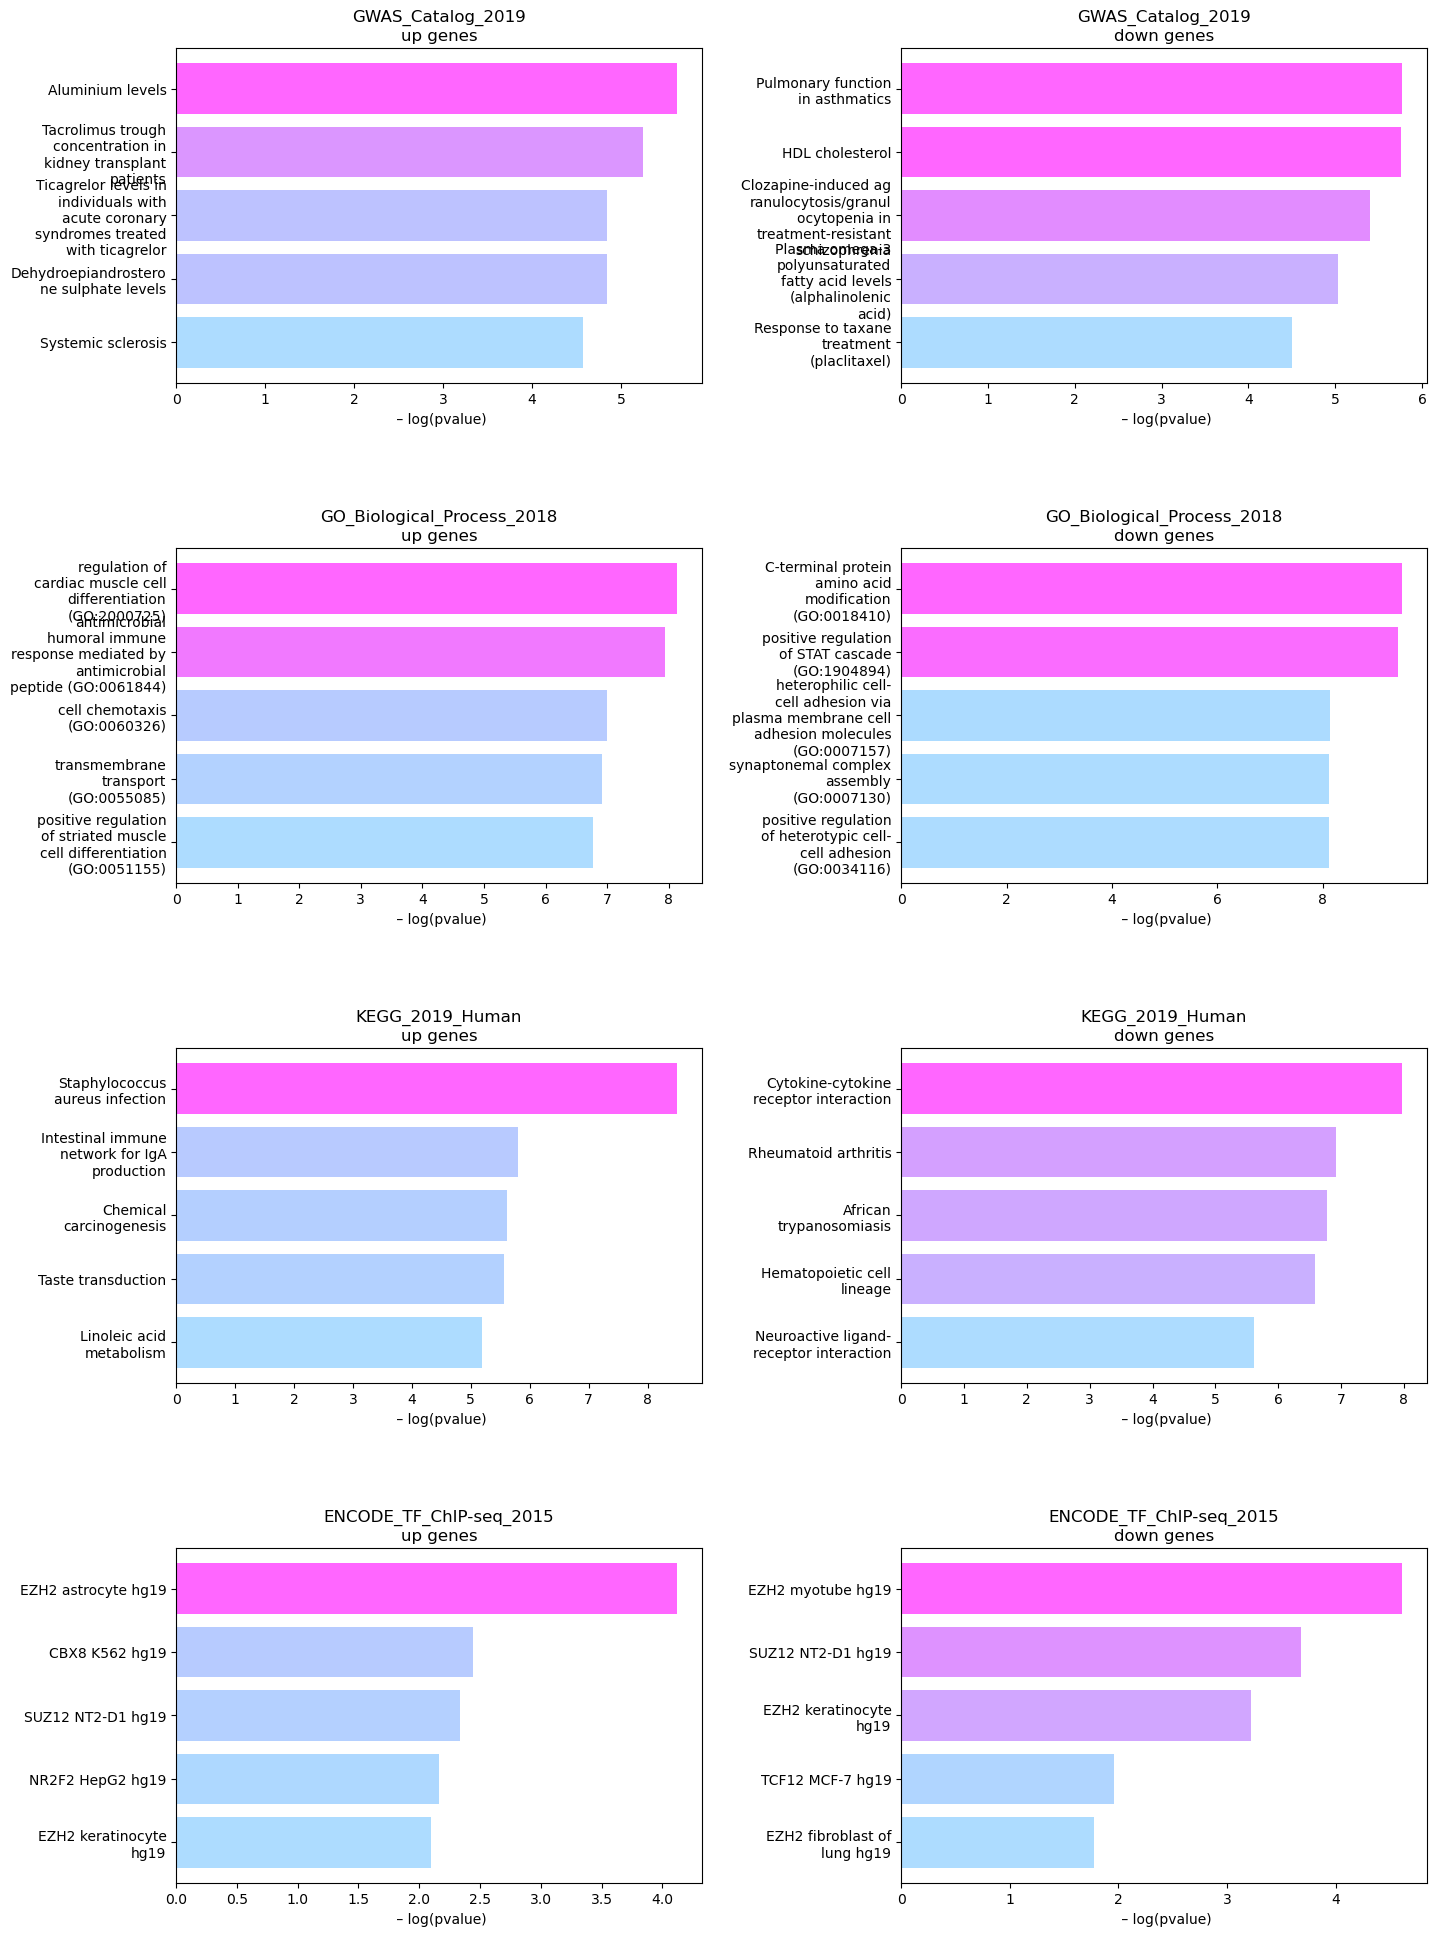

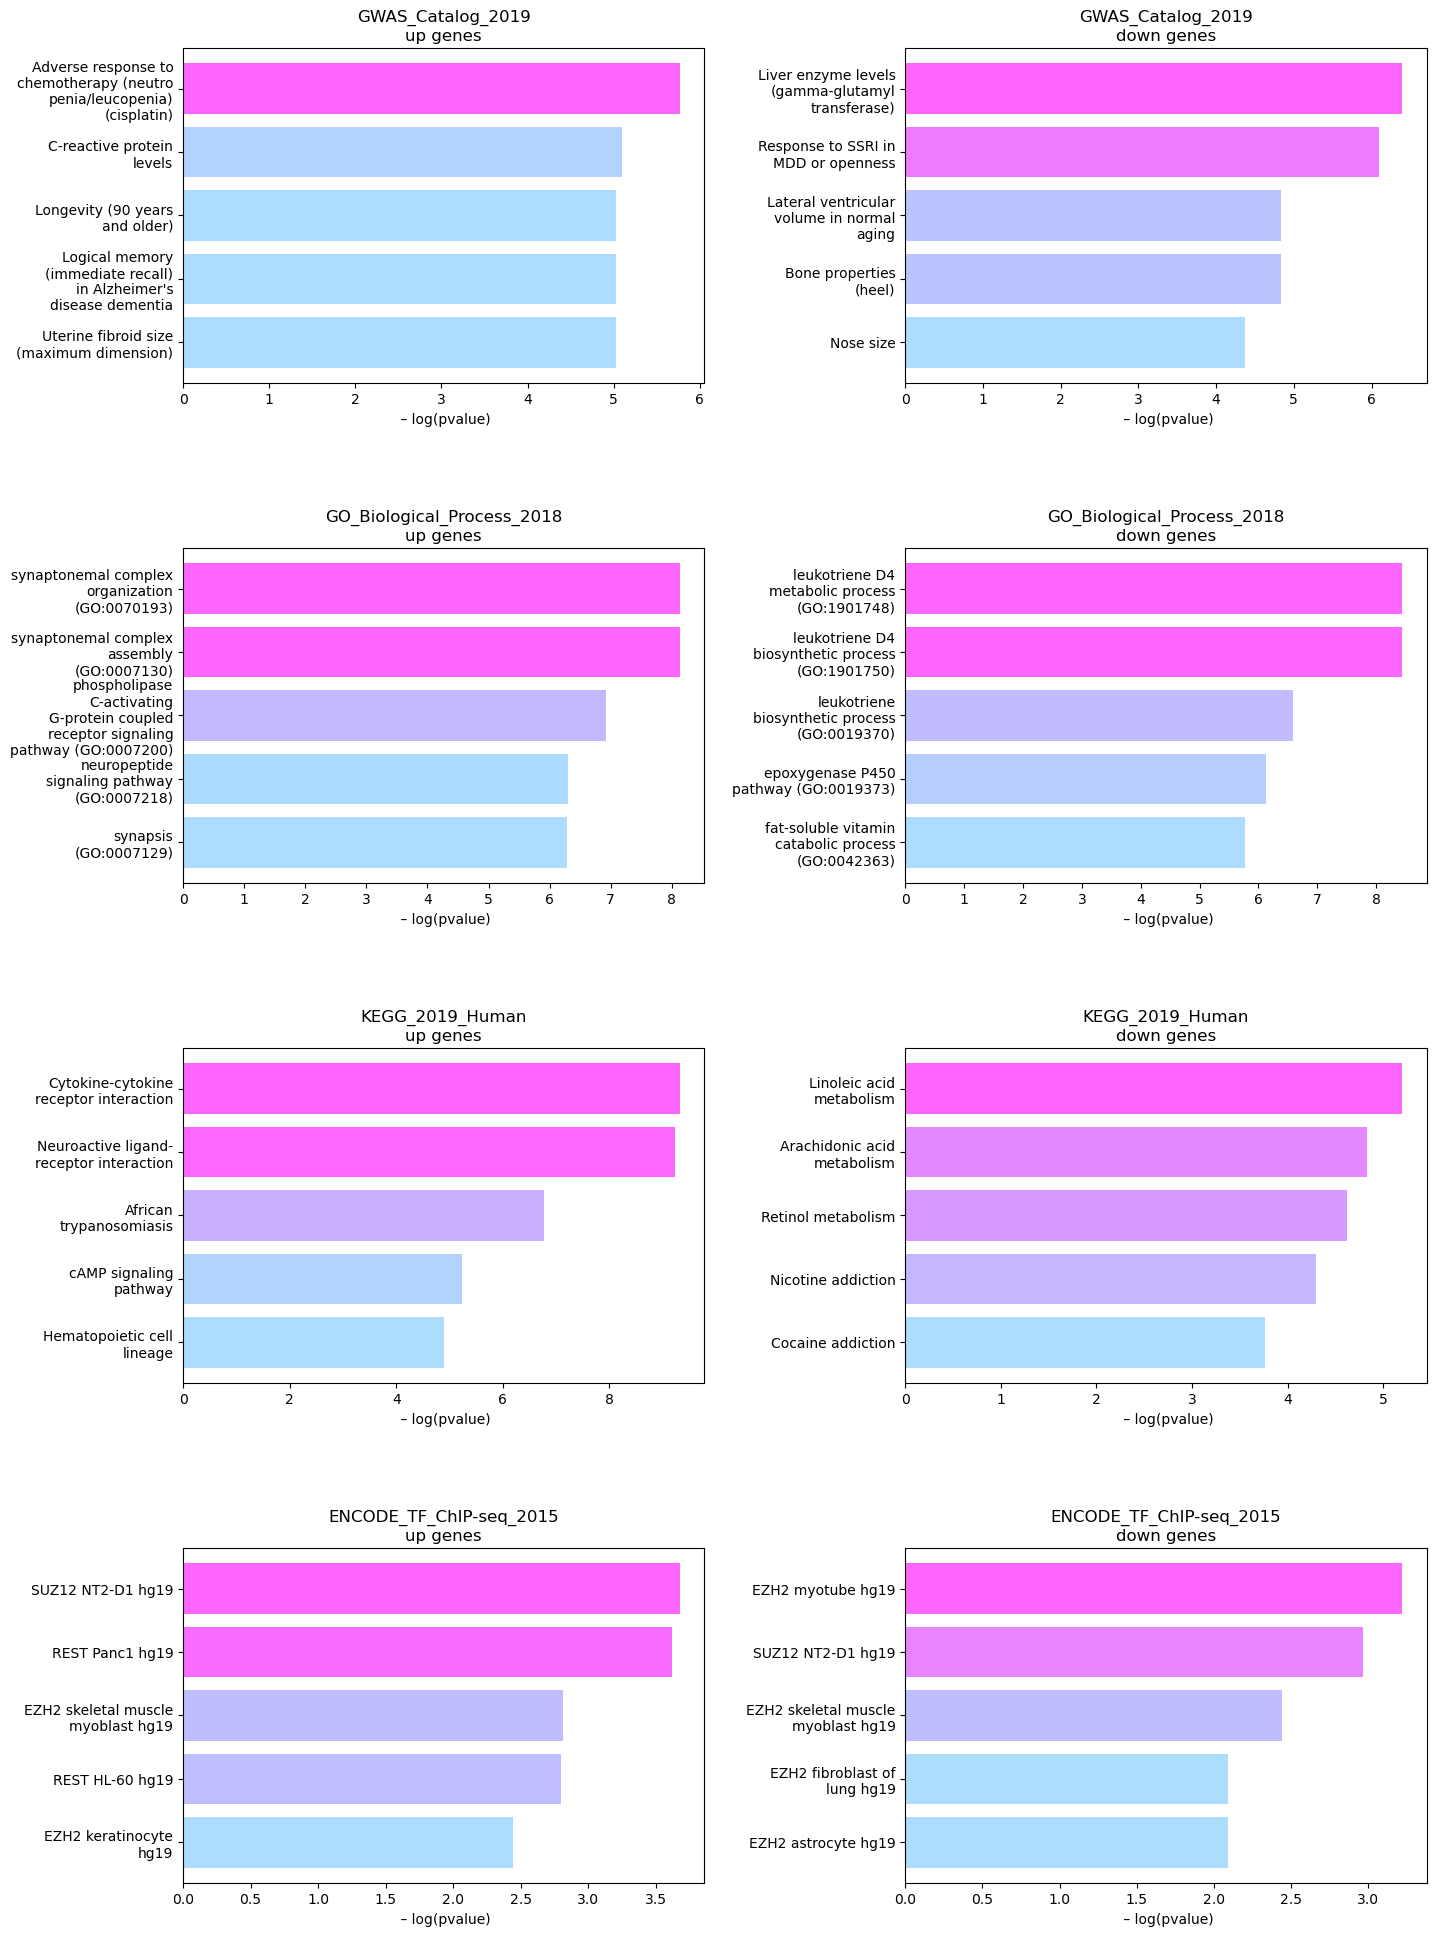

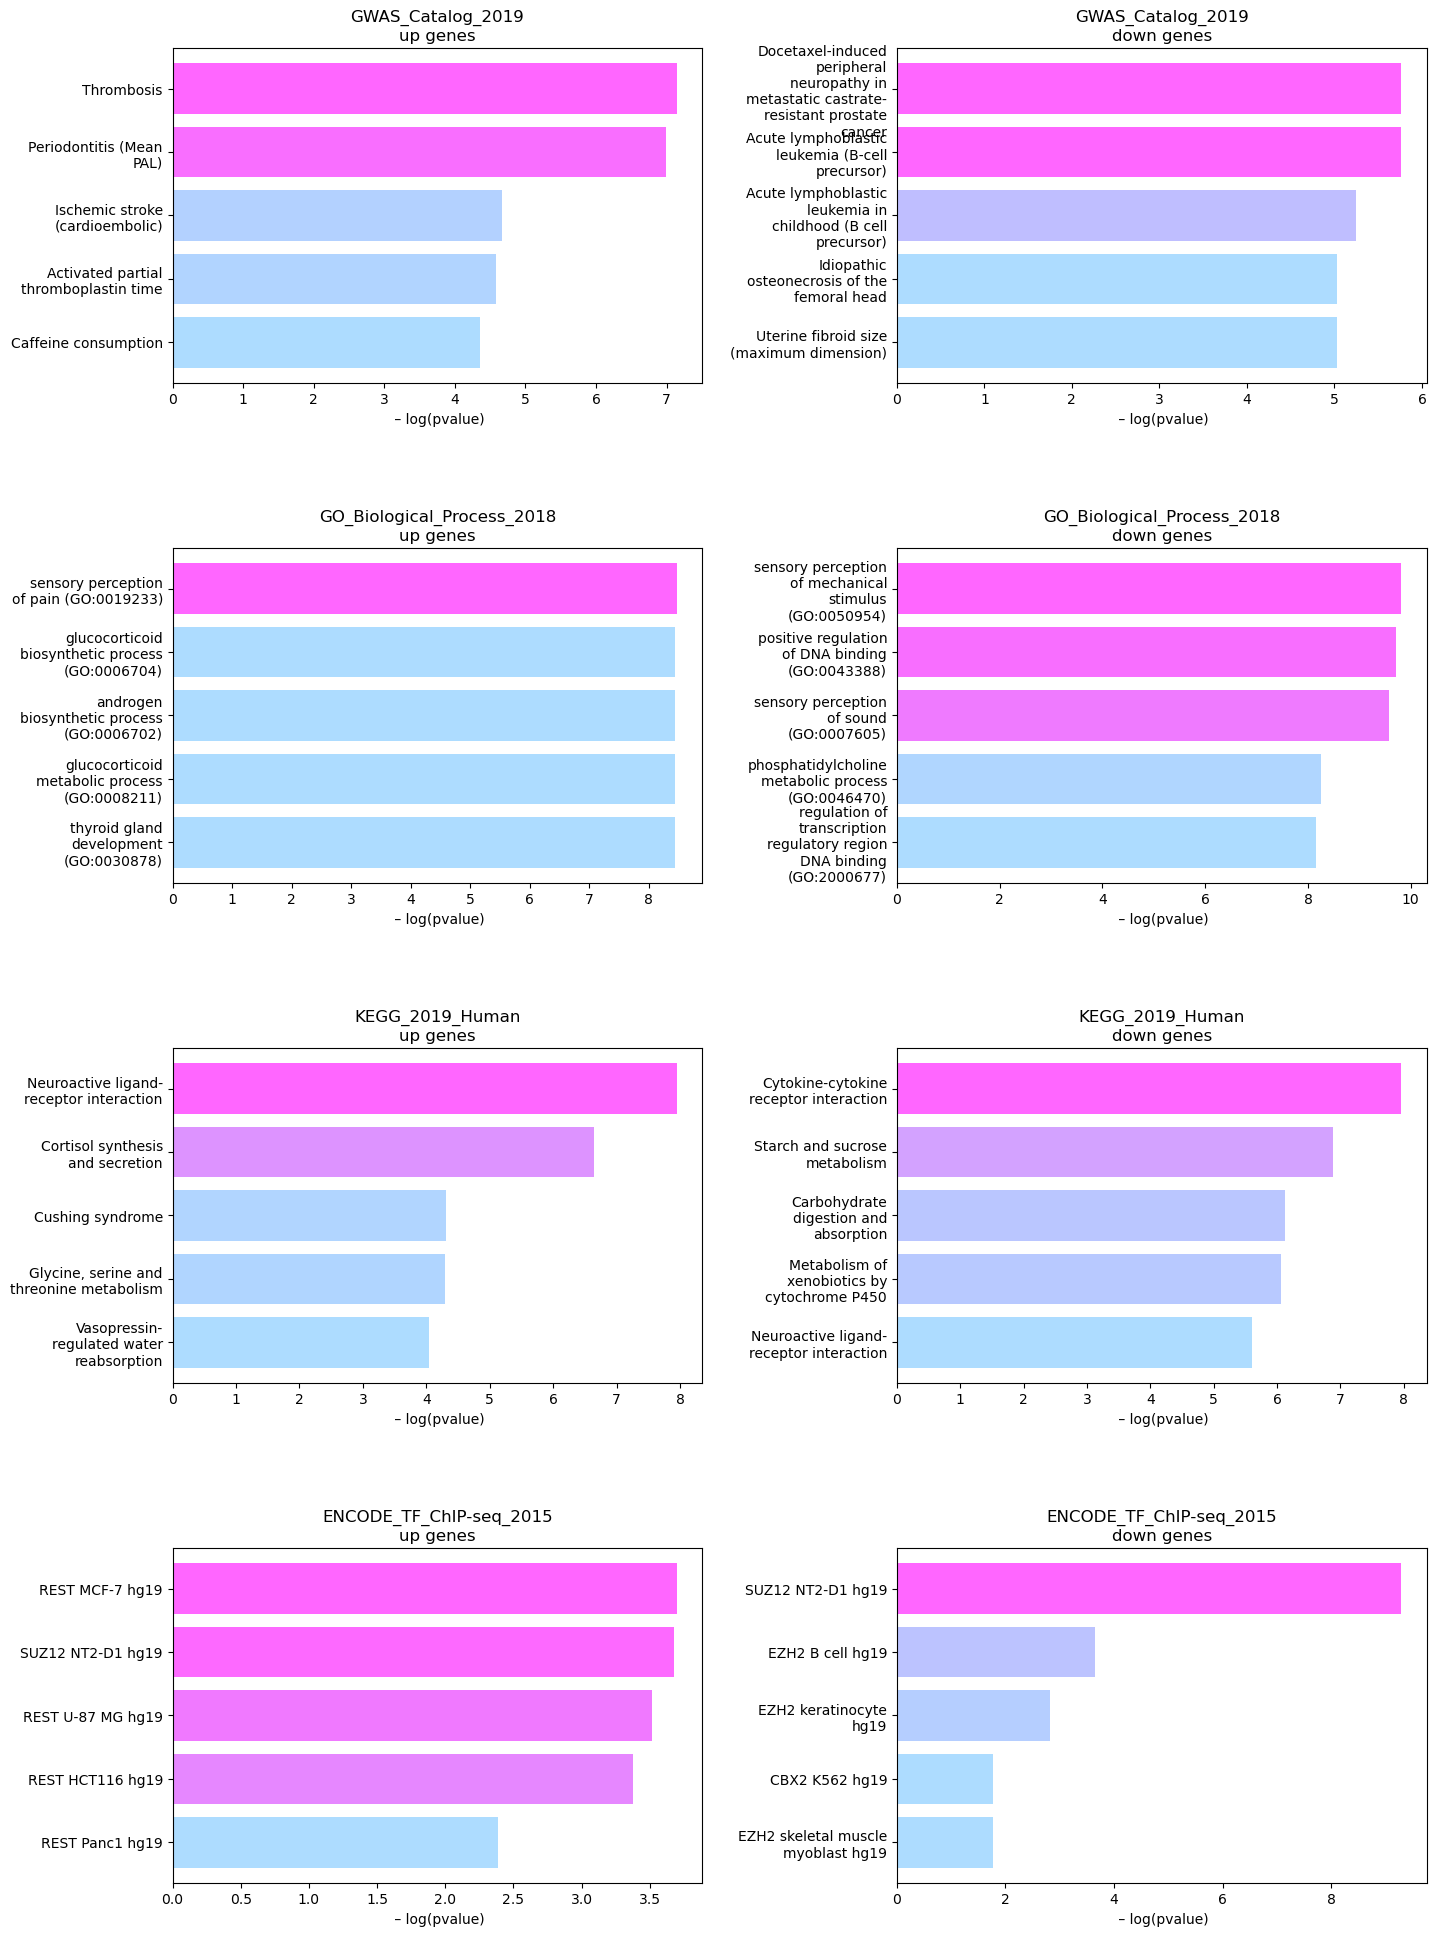

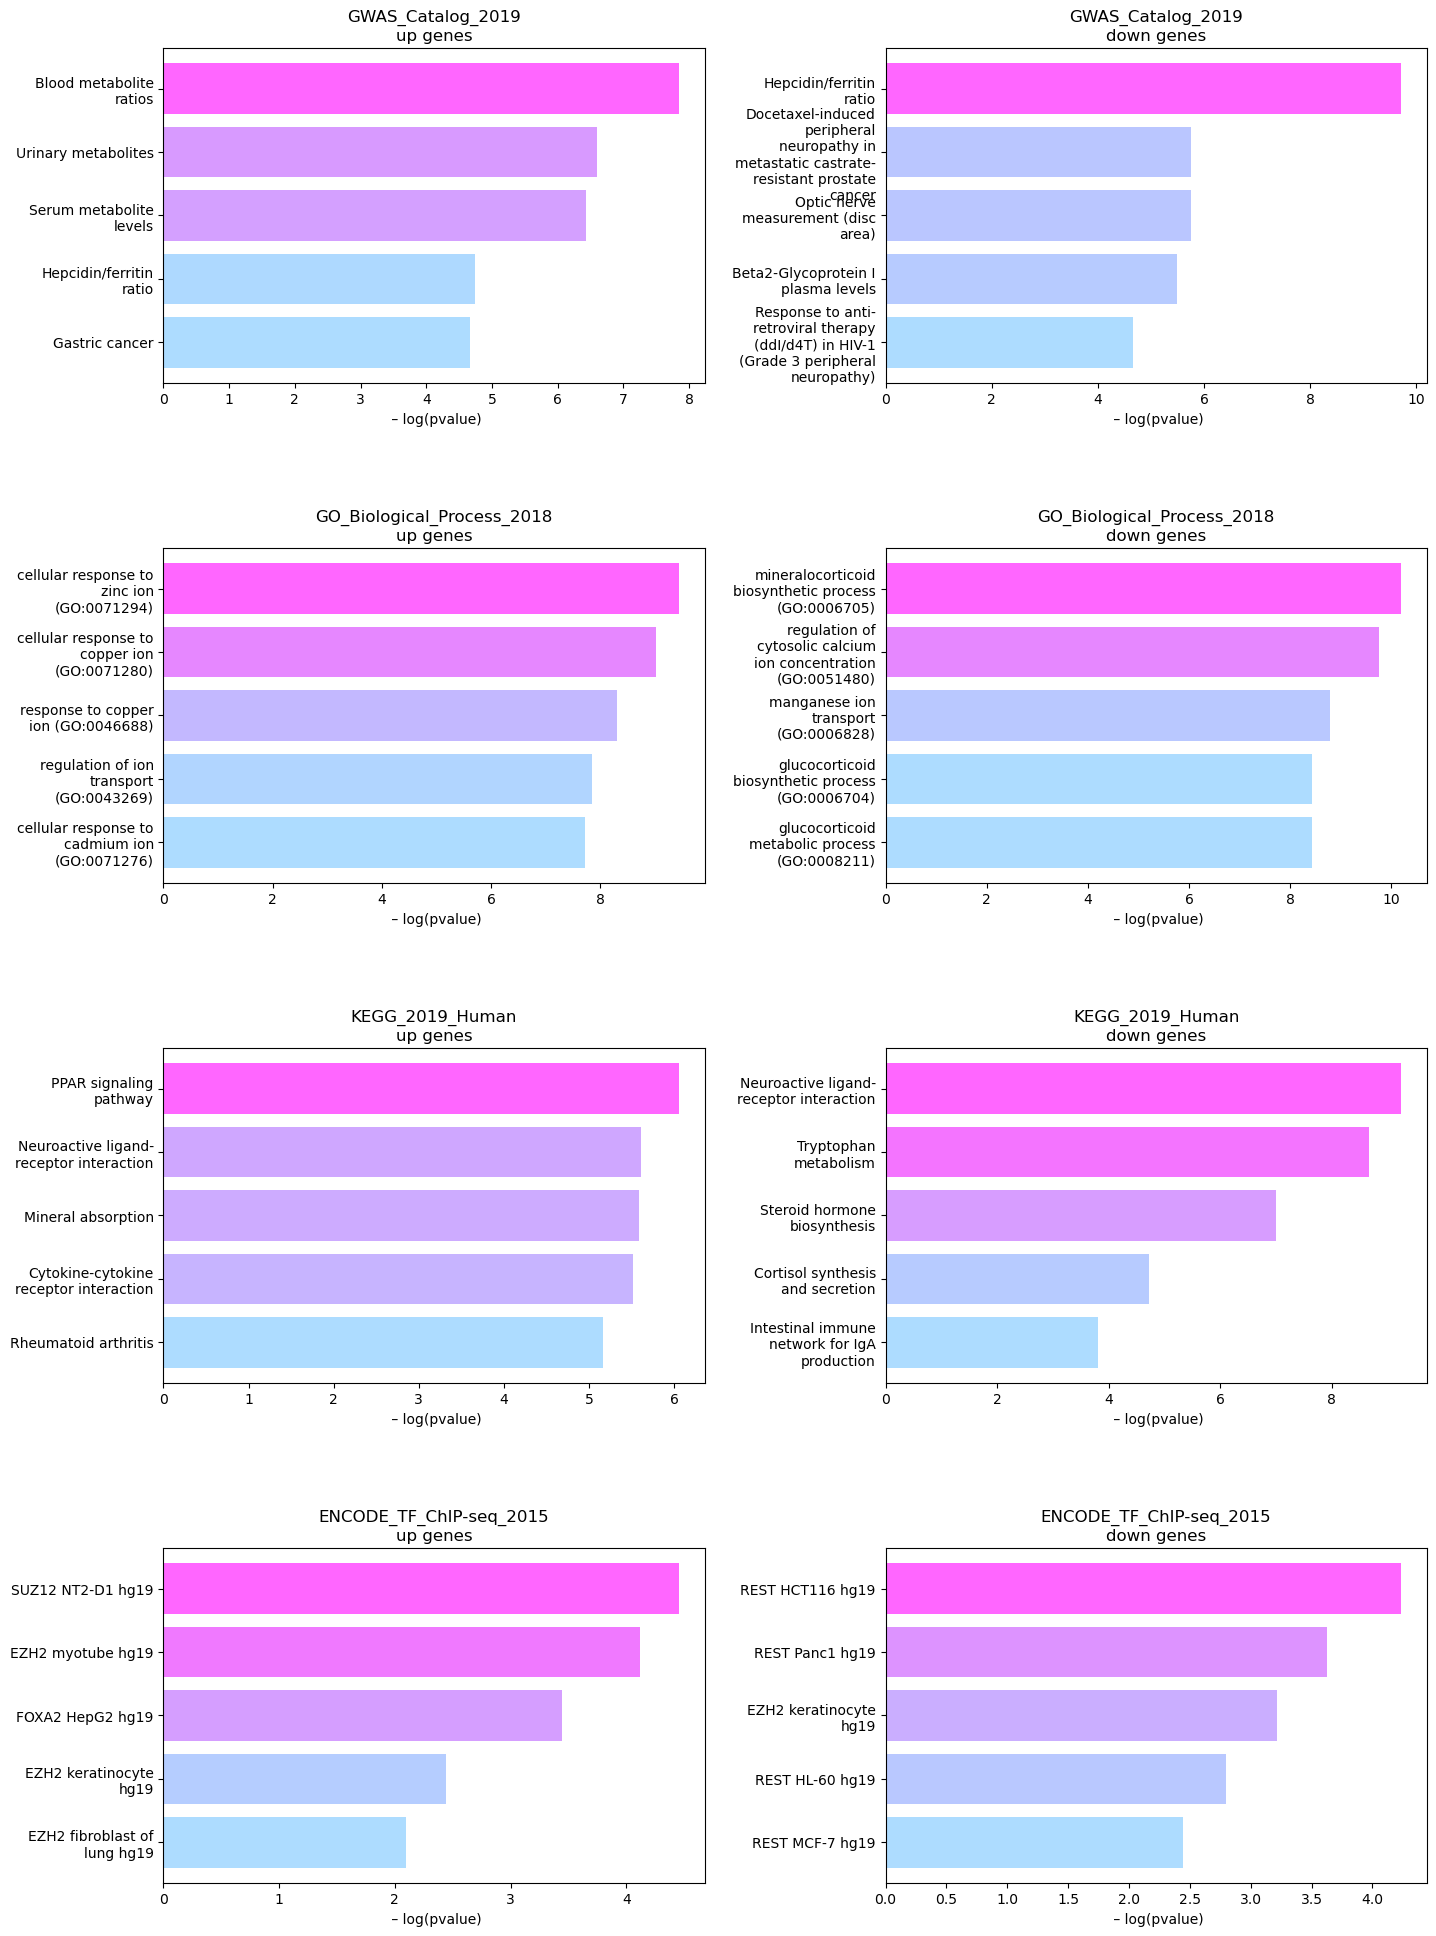

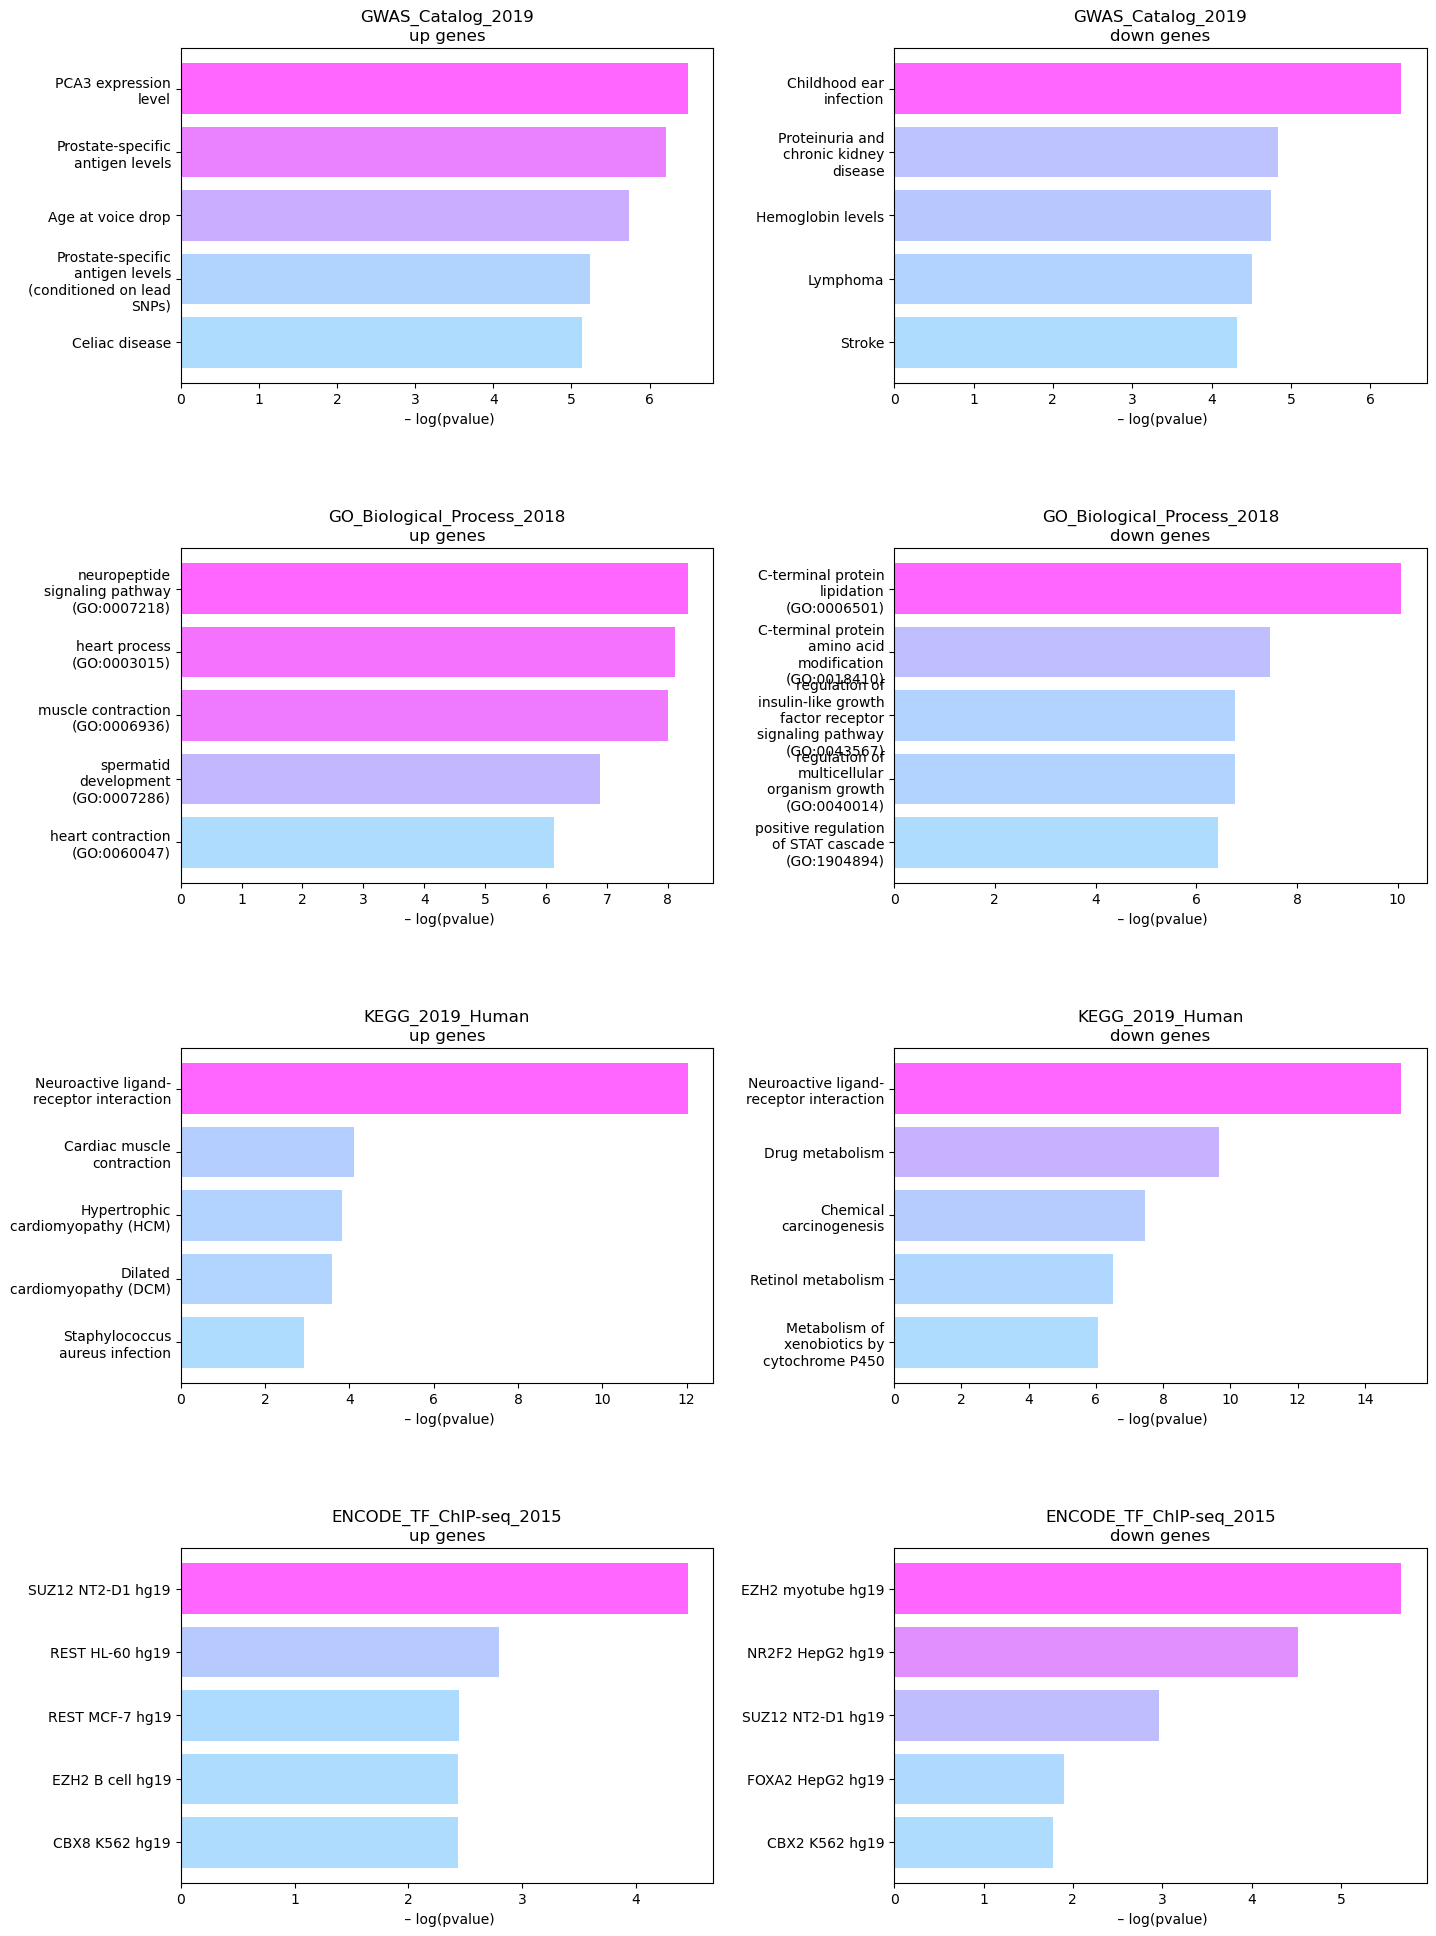

In [48]:
# Make horizontal barplots to visualize top Enrichr results
clusters = df_enrichr_results["cluster"].unique()
for cluster in clusters:
    cluster_results = df_enrichr_results.loc[df_enrichr_results["cluster"] == cluster, :]
    libraries = cluster_results["library"].unique()
    num_rows = len(libraries)

    count = 1 # keep track of which subplot we're on
    fig = plt.figure(figsize=(15,5*num_rows))
    
    for library in cluster_results["library"].unique():
            library_results = cluster_results.loc[cluster_results["library"] == library, :]
            for direction in library_results["direction"].unique():
                plot_results = library_results.loc[cluster_results["direction"] == direction, :]
                plot_results = plot_results.sort_values("pvalue",ascending=False)
                labels = plot_results["term"]
                labels = [ '\n'.join(wrap(l, 20)) for l in labels ]
                values = plot_results["pvalue"]
                values = -np.log(values)
                
                # normalize values to map from 0-1 -> color, with opacity also based on normalized pvalue
                cmap = plt.get_cmap('cool')
                norm_values = [ 0.3 + (x - min(values))/(max(values) - min(values))*0.7 for x in values]
                colors = [ [*cmap(val)[:3], 0.4  + 0.2*val] for val in norm_values]
                
                # plot result
                ax = fig.add_subplot(num_rows,2,count)
                ax.barh(labels,values,color = colors)
                ax.set_title(f'{library}\n{direction} genes')
                ax.set_xlabel(' – log(pvalue)')
                count += 1
                
    cluster_heading(cluster)
    #title = plt.suptitle(f'Cluster {cluster}',fontsize=24, color="white",bbox=(dict(facecolor=cluster_colors[cluster], alpha=0.8,pad=5)))
    fig.tight_layout(pad=3, w_pad=2, h_pad=6)
    plt.show()
    display(HTML("<br><br>"))
    
figure_legend("Figure 11", "Enrichment results by cluster", "Bar plots indicate the negative log of the p-value for the specified term. One plot is presented per cluster, per gene-set library, per expression direction (up/down).")

### 7b. Running Sum Visualizations
While the above barplots display the top enriched terms for each cluster in each direction, individual enriched terms can also be compared to the tissue data using a random walk [GSEA running sum visualization](https://github.com/MaayanLab/react-GSEA/tree/master).

First, the GWAS Catalog 2019 library of gene sets from Enrichr can be queried for a given term and its included genes. 

In [49]:
libresp = requests.get('https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=json&libraryName=GWAS_Catalog_2019')
if libresp.status_code != 200:
    raise Exception('Failed to access library geneset for comparison')

From the Enrichr results table, the complete set of genes associated with each enriched term can be accessed from the Enrichr library set up above. The code below extracts the geneset for the term that is most enriched for the up-regulated genes in Cluster 0.

In [50]:
# extract most enriched term from Enrichr results table
top_c0_term = df_enrichr_results[df_enrichr_results['cluster'] == '0']['term'].iloc[0]
# obtain geneset for that term
top_c0_geneset = list(libresp.json()['GWAS_Catalog_2019']['terms'][top_c0_term])
print(top_c0_term, top_c0_geneset)

Urinary metabolites ['PNMT', 'SLC6A19', 'DMGDH', 'ACSM3', 'PYROXD2', 'SLC6A13', 'SLC5A11', 'SLC6A20', 'WDR66', 'NAT8', 'SLC7A9', 'NAT2', 'CPS1', 'HPD', 'AGXT2', 'HIBCH', 'AGXT', 'XYLB']


This enriched geneset can then be compared to all of the genes in the tissue samples from Cluster 0. 

In the graph below, the line represents the running sum of the enrichment score. The x-axis denotes the rank of each gene in the tissue sample as ranked by expression, with the highest expressed gene across all samples on the far left and the lowest expressed gene on the far right. For every gene in the enriched geneset extracted above, if it is present in the tissue samples, then the value of the sum rises in the Enrichment Score graph, and a corresponding vertical line denotes at which rank the overlapping gene occurs in the weights graph. 

In [51]:
ReactGSEA(
  data=dataFromResult(input_set=top_c0_geneset,
                      ranked_entities=df_diff_expr['Cluster 0 CD'].sort_values(ascending=False).index.tolist()
))

**Figure 12:** *GSEA visualization for up-regulated Cluster 0 genes.* The above visualization compares the most enriched geneset from the Enrichr analysis to the highest-expressed genes in the Cluster 0 samples overall. Vertical lines in the Weights graph indicate overlapping genes between the tissue samples and the enriched geneset, with genes marked to the left of the midpoint of the Weights graph being upregulated in the tissue and genes marked to the right being downregulated in the tissue.

The same process from above can be repeated to compare the top enriched geneset from Cluster 1 with all of the genes expressed in the tissue sample. 

In [52]:
top_c1_term = df_enrichr_results[df_enrichr_results['cluster'] == '1']['term'].iloc[0]
top_c1_geneset = list(libresp.json()['GWAS_Catalog_2019']['terms'][top_c1_term])
print(top_c1_term, top_c1_geneset)

Adverse response to chemotherapy (neutropenia/leucopenia) (cisplatin) ['SFRS13AP2', 'SCARA5', 'LOC644534', 'AGR2', 'PTPN5', 'ZNF236', 'VAV3']


In [53]:
ReactGSEA(
  data=dataFromResult(input_set=top_c1_geneset,
                      ranked_entities=df_diff_expr['Cluster 1 CD'].sort_values(ascending=False).index.tolist()
))

**Figure 13:** *GSEA visualization for up-regulated Cluster 1 genes.* The above visualization compares the most enriched geneset from the Enrichr analysis to the highest-expressed genes in the Cluster 1 samples overall. Vertical lines in the Weights graph indicate overlapping genes between the tissue samples and the enriched geneset, with genes marked to the left of the midpoint of the Weights graph being upregulated in the tissue and genes marked to the right being downregulated in the tissue.